# Разработка модели прогноза удоя и вкуса молока для принятия решения о приобретении поголовья

## Введение

<b><u>Целевая задача Заказчика</b></u><i> - управление рисками при приобретении нового поголовья для молочного хозяйства "Вольный луг"</i><br>
В рамках реализации целевой задачи необходимо сформировать модели линейной и логистической регрессии, которые позволят спрогнозировать удой и вкус молока поголовья ЭкоФермы, необходимые для принятия объективного решения относительно приобретения поголовья

<b><i><u>Цели исследования</b></i><br>
1. разработка модели прогноза удоя коровы
2. расчет вероятноти получения молока, соответствующего стандартам качества хозяйства

<b><i><u>План работы</font>
1. загрузка, обзор и предобработка данных
    - загрузка библиотек
    - загрузка и обзор данных
    - предобработка данных
2. анализ данных
    - анализ данных о поголовье хозяйства "Вольный Луг"
    - анализ данных о поголовье ЭкоФермы
3. корреляционный анализ - анализ взаимосвязи показателей хозяйства "Вольный Луг"
4. разработка модели линейной регрессии, формирование прогноза удоя поголовья ЭкоФерма
5. разработка модели логистической регрессии, формирование прогноза вкуса молока поголовья ЭкоФерма
6. выводы по итогам исследования

## Загрузка и обзор днных

### Загрузка библиотек

In [8]:
# импорт основных библиотек
import pandas as pd
import os
import numpy as np
import sklearn
import math
import re
from scipy import stats
import phik
import warnings

# импорт модулей для разделения данных и создания моделей МО
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

# импорт модулей для расчета метрик
from sklearn.metrics import (mean_absolute_error, \
                            r2_score, \
                            mean_squared_error, \
                            recall_score,\
                            precision_score, \
                            accuracy_score, \
                            confusion_matrix)

# импорт модулей для масштабирования и кодирования
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

# Снимем ограничения на вывод данных в pandas-таблице
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

#выделение заголовков таблиц
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-weight", "bold"),
                   ("font-size", "120%"),
                   ("color", 'black')])]

### Загрузка и обзор данных

In [10]:
# функция для обзора данных
def display_df_info(data):
    display(data.head(5))
    print('-'*100)
    data.info()
    print('-'*100)
    print('Количество столбцов - {}, количество записей - {}'.format(data.shape[1], data.shape[0]))
   
    dupl = data.duplicated().sum()
    if dupl != 0:
        print('Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(dupl, dupl / data.shape[0]))
    else:
        print('Дубликаты записей не выявлены')
    
    if data.isnull().sum().sum() != 0:
            def pass_value_barh(data):
                try:
                    (data.isna().mean()*100).to_frame() \
                    .rename(columns = {0:'space'}) \
                    .query('space > 0') \
                    .sort_values(by = 'space', ascending = True) \
                    .plot(kind = 'barh', figsize = (10, 3), legend = False, fontsize = 8, color='royalblue', \
                                   title ='Пропущенные значения, %', \
                                   xlabel = 'Процент пропусков', \
                                   ylabel='Столбцы с пропусками', \
                                   grid=True, style='-',)
                    plt.show();    
                except:
                    print('Пропусков данных нет')
    else:
        print('Пропусков данных нет')

In [11]:
# загрузим предоставленные датасеты
path_global = 'C:\\Data_Science\\projects\\ECO_ferma'
## 1. данные о стаде фермера на текущий момент
pth1 = path_global + '\\ferma_main.csv'
## 2. данные о выручке, которую получает магазин с покупателя
pth2 = path_global + '\\ferma_dad.csv'
## 3. данные о времени (в минутах), которое покупатель провёл на сайте в течение периода
pth3 = path_global + '\\cow_buy.csv'

if os.path.exists(pth1):
    ferma_main = pd.read_csv(pth1, sep=';', decimal=",")
else:
    print('Something is wrong with pth1')
if os.path.exists(pth2):
    ferma_dad = pd.read_csv(pth2, sep=';', decimal=",")
else:
    print('Something is wrong  with pth2')
if os.path.exists(pth3):
    cow_buy = pd.read_csv(pth3, sep=';', decimal=",")
else:
    print('Something is wrong  with pth3')


In [12]:
# посмотрим общую информацию о представленных датасетах
display_df_info(ferma_main)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.20,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.08,вкусно,более_2_лет
1,2,5529,12.80,2138,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.08,вкусно,менее_2_лет
2,3,5810,14.00,1854,0.89,РефлешнСоверинг,Холмистое,Соверин,3.59,3.07,не вкусно,более_2_лет
3,4,5895,12.40,2012,0.89,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.08,не вкусно,более_2_лет
4,5,5302,12.80,1675,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.07,вкусно,менее_2_лет


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                63

In [13]:
display_df_info(ferma_dad)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 2, количество записей - 629
Дубликаты записей не выявлены
Пропусков данных нет


In [14]:
display_df_info(cow_buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 7, количество записей - 20
Выявлено 4 дубликатов записей, их количество составляет 20.00% от всех записей
Пропусков данных нет


### Предобработка данных

<u><i>Из информации о данных видно</u>,</i> что
1. во всех датасетах некорректное наименование колонок</br>
2. во всех датасетах нет пропусков данных</br>
3. в датасетах о поголовье хозяйств есть дубликаты данных</br>
4. не все данные соответсвуют типу: obj вместо int64</br>
    - ferma_info: 'ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%';</br>
    - cow_by: 'Текущая_жирность,%', 'Текущий_уровень_белок,%'

In [17]:
def column_name_snake(column_name):
    s1 = re.sub('(.)([A-Z][a-z])+', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def data_preparation(data):
   # data = data.drop_duplicates()
    data.columns = [column_name_snake(col) for col in data.columns]
    data.columns = data.columns.str.replace(' ', '_')
    return data

In [18]:
ferma_main = data_preparation(ferma_main)
ferma_main.head()
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   удой,_кг                               634 non-null    int64  
 2   эке_(энергетическая_кормовая_единица)  634 non-null    float64
 3   сырой_протеин,_г                       634 non-null    int64  
 4   спо_(сахаро-протеиновое_соотношение)   634 non-null    float64
 5   порода                                 634 non-null    object 
 6   тип_пастбища                           634 non-null    object 
 7   порода_папы_быка                       634 non-null    object 
 8   жирность,%                             634 non-null    float64
 9   белок,%                                634 non-null    float64
 10  вкус_молока                            634 non-null    object 
 11  возрас

In [19]:
ferma_main = ferma_main.rename(columns={'эке_(энергетическая_кормовая_единица)':'эке', 'спо_(сахаро-протеиновое_соотношение)':'спо'})
ferma_main.columns

Index(['id', 'удой,_кг', 'эке', 'сырой_протеин,_г', 'спо', 'порода',
       'тип_пастбища', 'порода_папы_быка', 'жирность,%', 'белок,%',
       'вкус_молока', 'возраст'],
      dtype='object')

In [20]:
cat_cols_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']
for col in cat_cols_names:
    print('\u001b[38;5;19m', ferma_main.groupby(col)[col].count())
    print('-'*100)

 порода
Вис Бик Айдиал     373
РефлешнСоверинг    261
Name: порода, dtype: int64
----------------------------------------------------------------------------------------------------
 тип_пастбища
Равнинное    253
Равнинные     25
Холмистое    356
Name: тип_пастбища, dtype: int64
----------------------------------------------------------------------------------------------------
 порода_папы_быка
Айдиал     240
Айдиалл     78
Соверин    316
Name: порода_папы_быка, dtype: int64
----------------------------------------------------------------------------------------------------
 вкус_молока
вкусно       371
не вкусно    263
Name: вкус_молока, dtype: int64
----------------------------------------------------------------------------------------------------
 возраст
более_2_лет    524
менее_2_лет    110
Name: возраст, dtype: int64
----------------------------------------------------------------------------------------------------


<i>Из результатов анализа данных о порроде, типе пастбища, вкуса молока и возраста животных видно, что есть опечатки<br>- в типе пастбища - `Равнинное` и `Равнинные` - явно один и тот же тип пастбищ<br>- в породе папы-быка - `Айдиал` и `Айдиалл`<br> Исправим опечатки в данных

In [22]:
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].replace(['Равнинные'], 'Равнинное')
ferma_main['порода_папы_быка'] = ferma_main['порода_папы_быка'].replace(['Айдиалл'], 'Айдиал')

In [23]:
# удалим явные дубликаты
ferma_main = ferma_main.drop_duplicates()
#проверим данные на неявные дубликаты
#дубликатами будем считать совпадения в столбцах с названием и адресом:
hidden_dupl = ferma_main.duplicated(subset=ferma_main.drop('id', axis=1)).sum()
if hidden_dupl != 0:
    print('\u001b[38;5;19m','Выявлено {:,.0f} неявных дубликата записей'.format(hidden_dupl))
    print('\u001b[38;5;19m','Их количество составляет {:.2%} от всех записей'.format(hidden_dupl / ferma_main.shape[0]))
else:
    print('\u001b[38;5;19m','Неявные дубликаты записей не выявлены')

 Неявные дубликаты записей не выявлены


In [24]:
ferma_dad = data_preparation(ferma_dad)
ferma_dad.head()

,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [25]:
cow_buy = data_preparation(cow_buy)
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет


In [26]:
# По итогу предобработки данных
print('\u001b[38;5;19m','Датасет ferma_main имеет следующие параметры')
display(ferma_main.describe(include=[object]))
display(ferma_main.describe())
print('\u001b[38;5;19m','Датасет ferma_dad имеет следующие параметры')
display(ferma_dad.describe(include=[object]))
display(ferma_dad.describe())
print('\u001b[38;5;19m','Датасет cow_buy имеет следующие параметры')
display(cow_buy.describe(include=[object]))
display(cow_buy.describe())

 Датасет ferma_main имеет следующие параметры


,порода,тип_пастбища,порода_папы_быка,вкус_молока,возраст
count,629,629,629,629,629
unique,2,2,2,2,2
top,Вис Бик Айдиал,Холмистое,Айдиал,вкусно,более_2_лет
freq,373,351,318,371,519


,id,"удой,_кг",эке,"сырой_протеин,_г",спо,"жирность,%","белок,%"
count,629.00,629.00,629.00,629.00,629.00,629.00,629.00
mean,315.00,"6,188.75",14.54,"1,923.36",0.91,3.60,3.08
std,181.72,"1,644.80",1.31,182.96,0.03,0.17,0.00
min,1.00,"5,204.00",10.90,"1,660.00",0.84,2.99,3.07
25%,158.00,"5,751.00",13.50,"1,771.00",0.89,3.59,3.07
50%,315.00,"6,133.00",14.70,"1,888.00",0.93,3.65,3.08
75%,472.00,"6,501.00",15.60,"2,062.00",0.94,3.72,3.08
max,629.00,"45,616.00",16.80,"2,349.00",0.96,3.75,3.08


 Датасет ferma_dad имеет следующие параметры


,имя_папы
count,629
unique,4
top,Барин
freq,240


,id
count,629.00
mean,315.00
std,181.72
min,1.00
25%,158.00
50%,315.00
75%,472.00
max,629.00


 Датасет cow_buy имеет следующие параметры


,порода,тип_пастбища,порода_папы_быка,имя_папы,возраст
count,20,20,20,20,20
unique,2,2,2,4,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,более_2_лет
freq,11,11,12,8,15


,"текущая_жирность,%","текущий_уровень_белок,%"
count,20.00,20.00
mean,3.58,3.07
std,0.13,0.01
min,3.34,3.05
25%,3.51,3.06
50%,3.59,3.07
75%,3.65,3.08
max,3.77,3.08


<font color='Darkblue'><b><i>Поскольку в дальнейшем будет необходимо сопоставлять данные о поголовье Экофермы и хозяйства Вольный луг, проверим на единообразность написания категориальных признаков

In [28]:
# Перед кодированием проверим сопоставимость значений в категориальных колонках
col_list = ['порода', 'порода_папы_быка', 'тип_пастбища', 'возраст']
print('\u001b[38;5;19m', 'Перечень уникальных значений в колонках датасета ferma_main')
for column_name in col_list:
    print('\u001b[38;5;19m', column_name, ferma_main[column_name].unique(), '\u001b[0m')
print('-'*100)
print('\u001b[38;5;19m', 'Перечень уникальных значений в колонках датасета cow_buy')
for column_name in col_list:
    print('\u001b[38;5;19m', column_name, cow_buy[column_name].unique(), '\u001b[0m')

 Перечень уникальных значений в колонках датасета ferma_main
 порода ['Вис Бик Айдиал' 'РефлешнСоверинг'] 
 порода_папы_быка ['Айдиал' 'Соверин'] 
 тип_пастбища ['Равнинное' 'Холмистое'] 
 возраст ['более_2_лет' 'менее_2_лет'] 
----------------------------------------------------------------------------------------------------
 Перечень уникальных значений в колонках датасета cow_buy
 порода ['Вис Бик Айдиал' 'РефлешнСоверинг'] 
 порода_папы_быка ['Айдиал' 'Соверин'] 
 тип_пастбища ['холмистое' 'равнинное'] 
 возраст ['более_2_лет' 'менее_2_лет'] 


In [29]:
# из данных выше видно, что написание типа пастбища различается - приведем к единому виду
cow_buy.replace({'холмистое': 'Холмистое', 'равнинное': 'Равнинное'}, inplace=True)
cow_buy['тип_пастбища'].unique()

array(['Холмистое', 'Равнинное'], dtype=object)

### Резюме

<font color='Darkblue'><b>A.</b> Для исследования предоставлено 3 датасета<br>&nbsp;&nbsp;&nbsp;<b>1) ferma_main</b> - данные о стаде фермера на текущий момент<br>&nbsp;&nbsp;&nbsp;<i>634 записи, 12 колонок, 5 дубикатов записей (неявных дубликатов нет), пропусков данных нет</i><br>`id` - уникальный идентификатор коровы,<br>`удой` - масса молока, которую корова даёт в год (в килограммах)<br>`ЭКЕ (Энергетическая кормовая единица)` -  показатель питательности корма коровы<br>`Сырой протеин, г` - содержание сырого протеина в корме (в граммах)<br>`СПО (Сахаро-протеиновое соотношение)` - отношение сахара к протеину в корме коровы<br>`Порода` - порода коровы<br>`Тип пастбища` - ландшафт лугов, на которых паслась корова<br>`порода папы_быка` - порода папы коровы<br>`Жирность,%` - содержание жиров в молоке<br>`Белок,%` - содержание беков в молоке<br>`Вкус молока` -  оценка вкуса по личным критериям фермера<br>`Возраст` - возраст коровы<br>&nbsp;&nbsp;&nbsp;<b>2) ferma_dad</b> - имя папы каждой коровы в стаде фермера<br>&nbsp;&nbsp;&nbsp;<i>629 записей, 2 колонки, дубликатов и пропусков записей нет</i><br>`id` - уникальный идентификатор коровы<br>`имя папы` - имя папы коровы<br>&nbsp;&nbsp;&nbsp;<b>3) cow_buy</b> - данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой<br>&nbsp;&nbsp;&nbsp;<i>20 записей, 7 колонок, 4 дубликата, пропусков данных нет</i><br>`Порода` - порода коровы<br>`тип_пастбища` - ландшафт лугов, на которых паслась корова<br>`порода папы быка` - порода папы коровы<br>`имя папы` - имя папы коровы<br>`текущая жирность,%` - содержание жиров в молоке<br>`текущий уровень белок,%` - содержание белков в молоке<br>`возраст` - возраст коровы<br><font color='Darkblue'><b>B.</b> В рамках предподготовки данных <br>&nbsp;&nbsp;&nbsp; - выявленные дубликаты в данных о поголовье хозяйства Вольный Луг удалены, о поголовье ЭкоФермы не удалены, т.к. предполагается, что это разные животные, наименовани колонок приведены к стандарту<br>&nbsp;&nbsp;&nbsp; - стандартизированы названия колонок<br>&nbsp;&nbsp;&nbsp; - изменен тип данных в колонках 'ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%', 'Текущая_жирность,%', 'Текущий_уровень_белок,%'

## Анализ данных

In [33]:
# для анализа показателей напишем функцию анализ распределения
def data_spread(data, column, ylabel, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    # строим график распределения
    x_values = pd.Series(range(0, len(data[column])))
    plt.scatter(x_values, data[column], color='royalblue')
    # задаем параметры подписи осей и графика
    plt.title('Распределение ' + title, color='navy', fontsize=11)
    #plt.xlabel(xlabel, color='navy', fontsize=8)
    plt.ylabel(ylabel, color='navy', fontsize=8)
    plt.xticks(color='navy', fontsize=8)
    plt.yticks(color='navy', fontsize=8)
    plt.grid(color='grey', linestyle='--')
    plt.minorticks_on()
    plt.grid(which='minor', color='gainsboro', ls=':')
    plt.show;

<font color='Darkblue'>Для дальнейшего анализа с учетом того, что данные в датасете `ferma_dad` - есть имена отцов коров, представленных в датасете `ferma_main`, считаю целеообразным объеденить датасеты в один - `ferma`

In [35]:
ferma = ferma_main.merge(ferma_dad, on='id')
ferma.head()

,id,"удой,_кг",эке,"сырой_протеин,_г",спо,порода,тип_пастбища,порода_папы_быка,"жирность,%","белок,%",вкус_молока,возраст,имя_папы
0,1,5863,14.20,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.08,вкусно,более_2_лет,Буйный
1,2,5529,12.80,2138,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.08,вкусно,менее_2_лет,Соловчик
2,3,5810,14.00,1854,0.89,РефлешнСоверинг,Холмистое,Соверин,3.59,3.07,не вкусно,более_2_лет,Барин
3,4,5895,12.40,2012,0.89,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.08,не вкусно,более_2_лет,Буйный
4,5,5302,12.80,1675,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.07,вкусно,менее_2_лет,Барин


### Анализ данных о поголовье молочного хозяйства «Вольный луг»

In [37]:
ferma.describe(percentiles=[.125, .5, .875])

,id,"удой,_кг",эке,"сырой_протеин,_г",спо,"жирность,%","белок,%"
count,629.00,629.00,629.00,629.00,629.00,629.00,629.00
mean,315.00,"6,188.75",14.54,"1,923.36",0.91,3.60,3.08
std,181.72,"1,644.80",1.31,182.96,0.03,0.17,0.00
min,1.00,"5,204.00",10.90,"1,660.00",0.84,2.99,3.07
12.5%,79.50,"5,524.50",12.90,"1,715.00",0.88,3.34,3.07
50%,315.00,"6,133.00",14.70,"1,888.00",0.93,3.65,3.08
87.5%,550.50,"6,699.00",16.20,"2,177.00",0.94,3.73,3.08
max,629.00,"45,616.00",16.80,"2,349.00",0.96,3.75,3.08


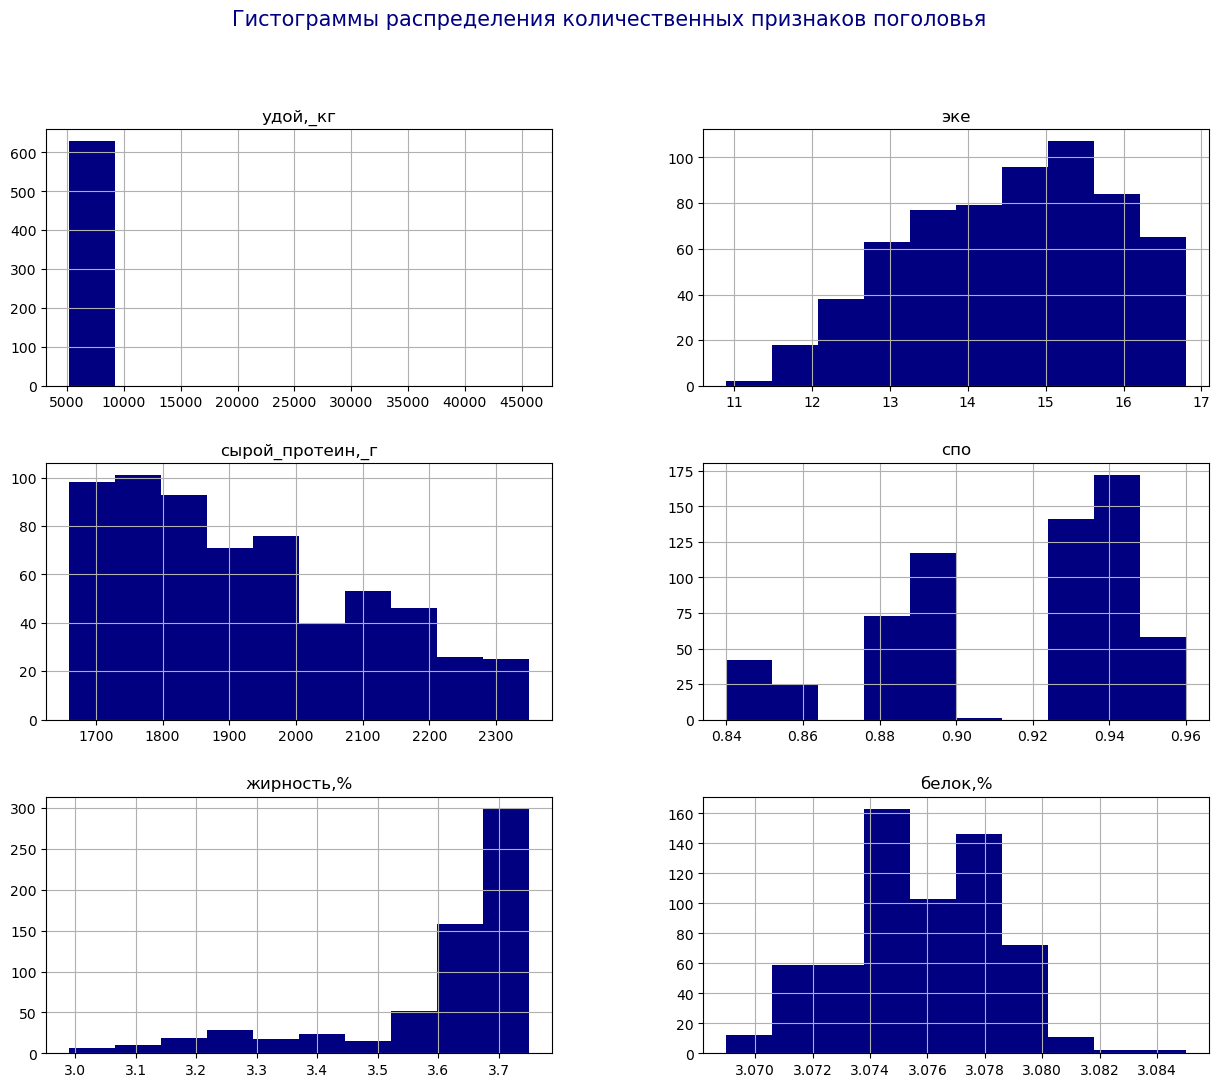

In [38]:
cols_ferma_num = ['удой,_кг', 'эке', 'сырой_протеин,_г', 'спо', 'жирность,%', 'белок,%']
ferma[cols_ferma_num].hist(figsize=(15,12), color='navy')
plt.suptitle("Гистограммы распределения количественных признаков поголовья", fontsize=15, color='navy');

<font color='Darkblue'><b><i>В данных об удое виден выброс - максимальное значени 45,6 тыс кг в год выбивается из средних показателей для коров фермерского стада</b> Посмотрим на распределение значений удоя в целом по стаду

In [40]:
ferma[ferma['удой,_кг'] > 10000]

,id,"удой,_кг",эке,"сырой_протеин,_г",спо,порода,тип_пастбища,порода_папы_быка,"жирность,%","белок,%",вкус_молока,возраст,имя_папы
16,17,45616,11.50,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.08,вкусно,более_2_лет,Буйный


<font color='Darkblue'><i>Из представленной таблицы можно сделать вывод, что веротнее всего в данные закарлась ошибка, которую целесообразно удалить (поскольку это единичное значение - потери качества данных не произойдет)

In [42]:
ferma = ferma[ferma['удой,_кг'] < 10000]

In [43]:
print('\u001b[38;5;19m', 'После удаления данных по аномальному удою количество записей в датасете сократилось до', ferma_main.shape[0])

 После удаления данных по аномальному удою количество записей в датасете сократилось до 629


In [44]:
ferma['удой,_кг'].describe(percentiles=[.125, .5, .875])

count     628.00
mean    6,125.97
std       475.86
min     5,204.00
12.5%   5,523.38
50%     6,132.50
87.5%   6,695.12
max     7,222.00
Name: удой,_кг, dtype: float64

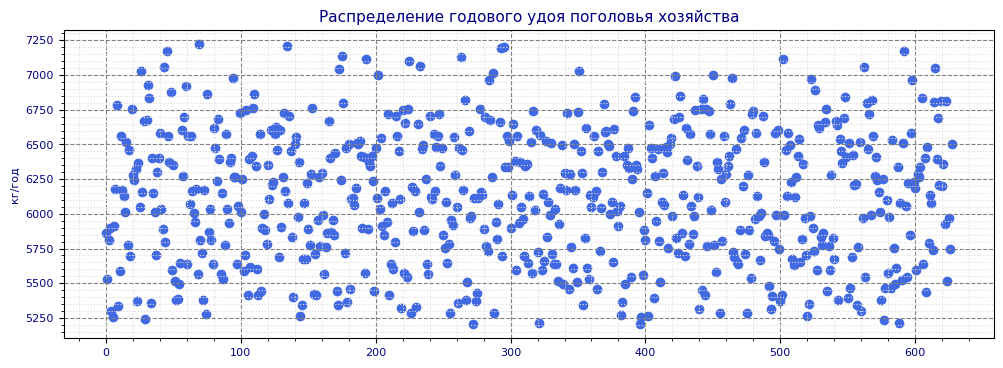

In [45]:
# посмотрим на распределение признака после удаления аномального значения
data_spread(ferma, 'удой,_кг', 'кг/год', 'годового удоя поголовья хозяйства')

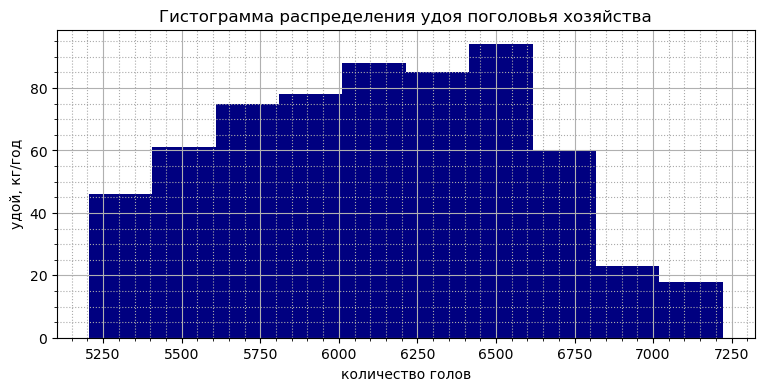

In [46]:
ferma['удой,_кг'].hist(figsize=(9,4), color='navy')
plt.title("Гистограмма распределения удоя поголовья хозяйства")
plt.xlabel("количество голов")
plt.ylabel("удой, кг/год")
plt.minorticks_on()
plt.grid(which='minor', color='#aaa', ls=':')

<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'>1. Показатели кормовой базы:<br>&nbsp;&nbsp;&nbsp;- `эке (энергетические кормовые единицы)`: показатель нормально распределен, у 75% поголовья в рационе эко в рационе находится в диапазоне 12.9-16.2 ед., средние эке составляют 14.5 и смещено влево от наиболее распространенного (15.5) и медианного (14.7) значений,<br>&nbsp;&nbsp;&nbsp;- `сырой протеин`: ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды), у 75% поголовья в рационе сырой протеин в рационе находится в диапазоне 1.7 - 2.2 тыс гр., средний протеин составляют 1.92 тыс.гр. и смещен вправо от наиболее распространенного (1.75 тыс.гр) и медианного значений(1.89 тыс.гр), ,<br>&nbsp;&nbsp;&nbsp;- `спо (сахаро-протеиновое соотношение)`: на гистограмме видны три четкие области концентрации значений - в диапазоне от 0.84 до 0.86, в диапазоне от 0.88 до 0.90 и в диапазоне от 0.93 до 0.96, где сконцентрированно наибольшее количество значений, средний показатель спо составляет 0.91<br>2. Показатели молока:<br>&nbsp;&nbsp;&nbsp;- `удой`(после удаления аномального значения): показатель нормально распределен, у 75% поголовья удой нахдоится в диапазоне 5.5 - 6.7 тыс кг/год, средний и медианный удой составляет 6.1 тыс кг/год и незначительно смещен влево от наиболее распространенного (6.5) значения,<br>&nbsp;&nbsp;&nbsp;- `жирность`: ассиметричное распределение значений показателя - отрицательная ассиметрия (большинство значений показателя расположена слева от моды), видно 2 четкие области концентрации значений - около 3.6% и около 3.7%, где сконцентрированно наибольшее количество значений, средний показатель жирности составляет 3.6%, что не сильно отличается от медианного - 3.65%,<br>&nbsp;&nbsp;&nbsp;- `белок`: незначительное ассиметричное смещение значений показателя в диапазоне 3.07% - 3.08%, средний и медианный показатель белка совпададют и составляют 3.08%

In [49]:
cat_cols_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст', 'имя_папы']
for col in cat_cols_names:
    print('\u001b[38;5;19m', ferma.groupby(col)[col].count())
    print('-'*100)

 порода
Вис Бик Айдиал     372
РефлешнСоверинг    256
Name: порода, dtype: int64
----------------------------------------------------------------------------------------------------
 тип_пастбища
Равнинное    278
Холмистое    350
Name: тип_пастбища, dtype: int64
----------------------------------------------------------------------------------------------------
 порода_папы_быка
Айдиал     317
Соверин    311
Name: порода_папы_быка, dtype: int64
----------------------------------------------------------------------------------------------------
 вкус_молока
вкусно       370
не вкусно    258
Name: вкус_молока, dtype: int64
----------------------------------------------------------------------------------------------------
 возраст
более_2_лет    518
менее_2_лет    110
Name: возраст, dtype: int64
----------------------------------------------------------------------------------------------------
 имя_папы
Барин       240
Буйный      214
Геркулес     64
Соловчик    110
Name: имя_папы, dtyp

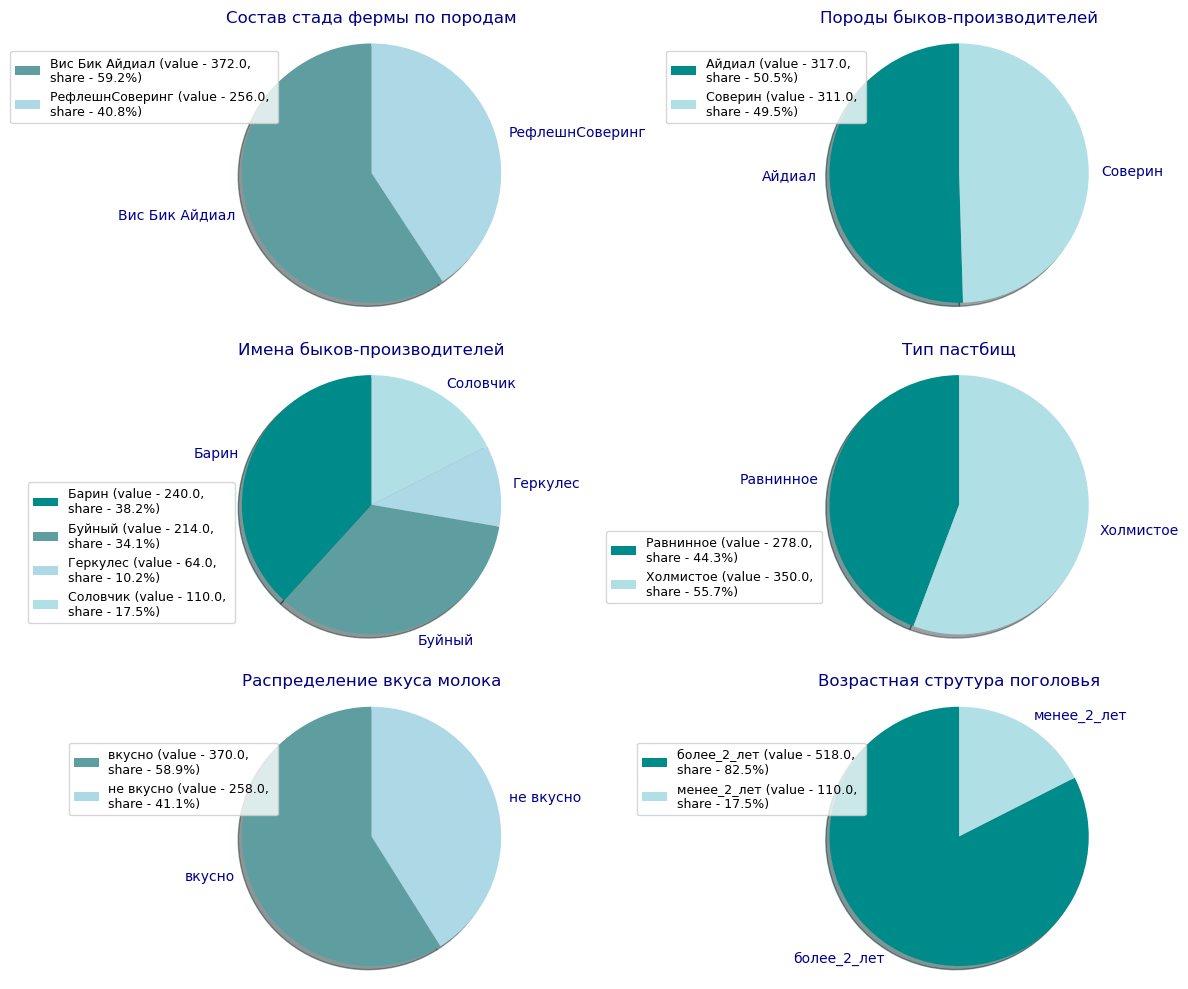

In [50]:
plt.figure(figsize=(12, 10))

#порода коров
breed_cow = ferma.groupby('порода', as_index=False).agg({'id':'nunique'})
ax1 = plt.subplot(3, 2, 1)
labels = list(breed_cow['порода'])
values = breed_cow['id']
total = sum(values)
colors = ['cadetblue','lightblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Состав стада фермы по породам', color='navy')
plt.axis('equal')

#порода быков
breed_beef = ferma.groupby('порода_папы_быка', as_index=False).agg({'id':'nunique'})
ax2 = plt.subplot(3, 2, 2)
labels = list(breed_beef['порода_папы_быка'])
values = breed_beef['id']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Породы быков-производителей', color='navy')
plt.axis('equal')

#имена быков
beef_name = ferma.groupby('имя_папы', as_index=False).agg({'id':'nunique'})
ax3 = plt.subplot(3, 2, 3)
labels = list(beef_name['имя_папы'])
values = beef_name['id']
total = sum(values)
colors = ['darkcyan', 'cadetblue','lightblue', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0, 0.27, 0.2, 0.33),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Имена быков-производителей', color='navy')
plt.axis('equal')

#тип пастбища
pasture = ferma.groupby('тип_пастбища', as_index=False).agg({'id':'nunique'})
ax4 = plt.subplot(3, 2, 4)
labels = list(pasture['тип_пастбища'])
values = pasture['id']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0, 0.1, 0.2, 0.33),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Тип пастбищ', color='navy')
plt.axis('equal')

#вкус молока
milk_taste = ferma.groupby('вкус_молока', as_index=False).agg({'id':'nunique'})
ax5 = plt.subplot(3, 2, 5)
labels = list(milk_taste['вкус_молока'])
values = milk_taste['id']
total = sum(values)
colors = ['cadetblue','lightblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.5, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Распределение вкуса молока', color='navy')
plt.axis('equal')

#возраст коров
cow_age = ferma.groupby('возраст', as_index=False).agg({'id':'nunique'})
ax6 = plt.subplot(3, 2, 6)
labels = list(cow_age['возраст'])
values = cow_age['id']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.5, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Возрастная струтура поголовья', color='navy')
plt.axis('equal')

plt.tight_layout()
plt.show();

<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'>Категорийные данные о поголовье хозяйства "Вольный луг"<br>&nbsp;&nbsp;&nbsp;1) `порода` - в стаде представлено две породы: ВисБикАйдал и РефлешнсСоверинг, - незначительно превалируют коровы породы ВисБикАйдал (59.2%)<br>&nbsp;&nbsp;&nbsp;2) `порода быков-производителей` - в стаде 50Х50 представлены коровы от двух пород быков: Айдиал и Соверин<br>&nbsp;&nbsp;&nbsp;3) `имя быка производителя` - в стаде потомство от 4х быков, наибольшая доля голов от быка Барин (38.2%) и быка Буйный (34.1%)<br>&nbsp;&nbsp;&nbsp;4) `пастбища` - два типа пастбищ: Равнинное и Холмистое, - незначительно превалирует поголовье, с выпасом на Холмистых пастбищах (55.7%)<br>&nbsp;&nbsp;&nbsp;5) `вкус молока` - незначительно, но превалирует оценка вкусно - 58.9%<br>&nbsp;&nbsp;&nbsp;6) `возраст коров` - в стаде превалируют животные старше 2х лет - 82.5%

### Анализ данных о поголовье «ЭкоФермы»

In [54]:
cow_buy.describe(percentiles=[.125, .5, .875])

,"текущая_жирность,%","текущий_уровень_белок,%"
count,20.00,20.00
mean,3.58,3.07
std,0.13,0.01
min,3.34,3.05
12.5%,3.40,3.05
50%,3.59,3.07
87.5%,3.73,3.08
max,3.77,3.08


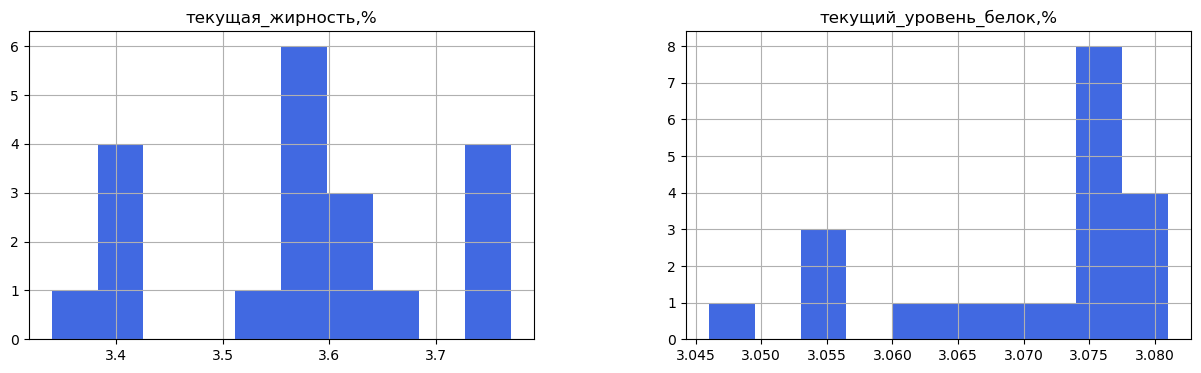

In [55]:
num_cols_names_buy = ['текущая_жирность,%', 'текущий_уровень_белок,%']
cow_buy[num_cols_names_buy].hist(figsize=(15,4), color='royalblue');

<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'>Показатели молока:<br>&nbsp;&nbsp;&nbsp;- `жирность`: аномальных значений нет, значения находятся в диапазоне от 3.34% до 3.77%, видно 3 четкие области концентрации значений - 3.4%, 3.8% и 3.55%-3.65%, где сконцентрированно наибольшее количество значений, средний показатель жирности составляет 3.58%, что не сильно отличается от медианного - 3.59% ,<br>&nbsp;&nbsp;&nbsp;- `белок`: аномальных значений нет, значения находятся в диапазоне от 3.05% до 3.08%, наибольшее количество значений приходится на диапазон от 3.05% - 3.08%, медианное и среднее значение совпадают - 3.07%

In [58]:
cat_cols_names_buy = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст']
for col in cat_cols_names_buy:
    print('\u001b[38;5;19m', cow_buy.groupby(col)[col].count())
    print('-'*100)

 порода
Вис Бик Айдиал      9
РефлешнСоверинг    11
Name: порода, dtype: int64
----------------------------------------------------------------------------------------------------
 тип_пастбища
Равнинное    11
Холмистое     9
Name: тип_пастбища, dtype: int64
----------------------------------------------------------------------------------------------------
 порода_папы_быка
Айдиал      8
Соверин    12
Name: порода_папы_быка, dtype: int64
----------------------------------------------------------------------------------------------------
 имя_папы
Барин       4
Буйный      8
Геркулес    6
Соловчик    2
Name: имя_папы, dtype: int64
----------------------------------------------------------------------------------------------------
 возраст
более_2_лет    15
менее_2_лет     5
Name: возраст, dtype: int64
----------------------------------------------------------------------------------------------------


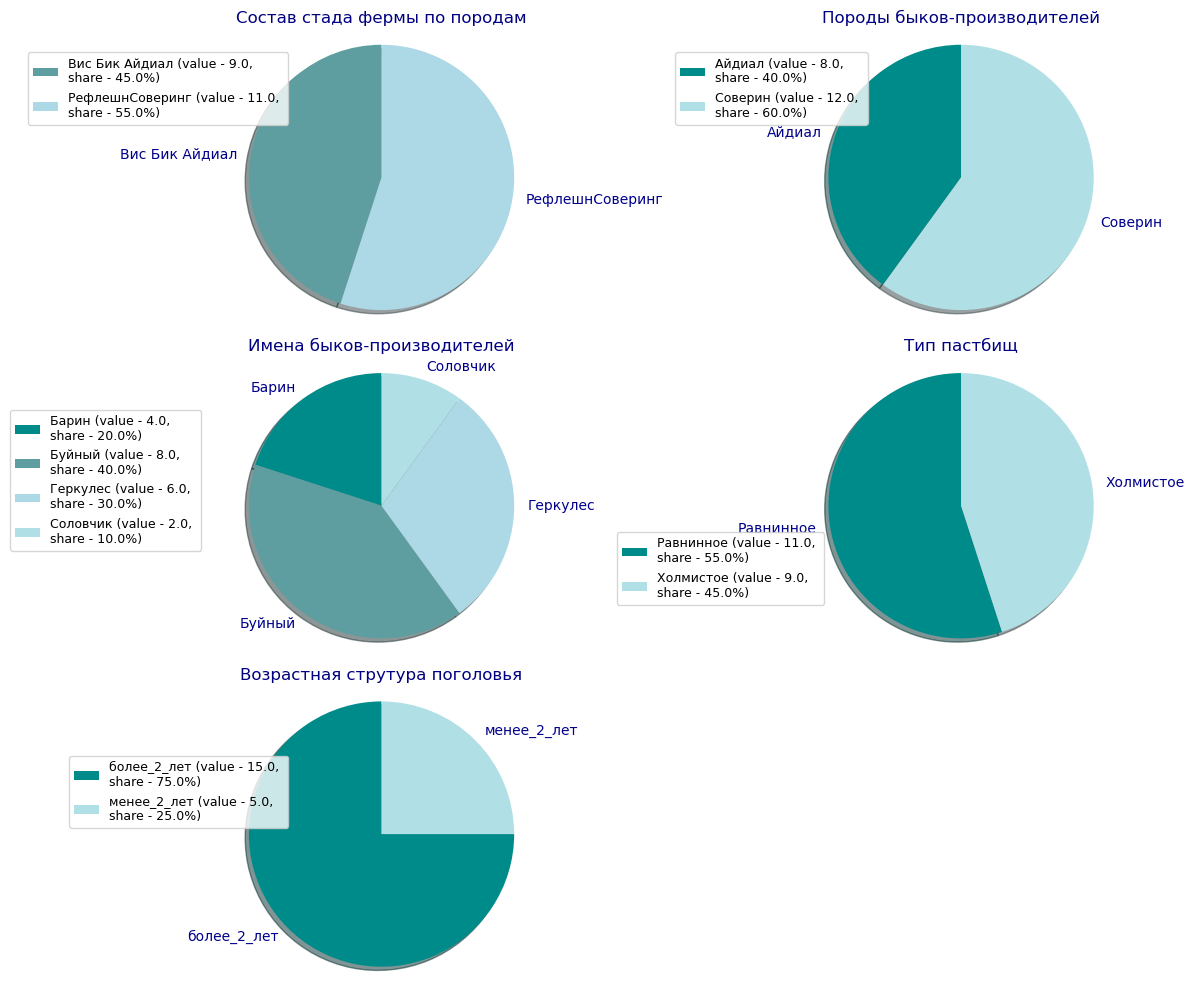

In [59]:
plt.figure(figsize=(12, 10))

#порода коров
breed_cow_buy = cow_buy.groupby('порода', as_index=False).agg({'текущая_жирность,%':'count'})
ax1 = plt.subplot(3, 2, 1)
labels = list(breed_cow_buy['порода'])
values = breed_cow_buy['текущая_жирность,%']
total = sum(values)
colors = ['cadetblue','lightblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Состав стада фермы по породам', color='navy')
plt.axis('equal')

#порода быков
breed_beef_buy = cow_buy.groupby('порода_папы_быка', as_index=False).agg({'текущая_жирность,%':'count'})
ax2 = plt.subplot(3, 2, 2)
labels = list(breed_beef_buy['порода_папы_быка'])
values = breed_beef_buy['текущая_жирность,%']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Породы быков-производителей', color='navy')
plt.axis('equal')

#имена быков
beef_name_buy = cow_buy.groupby('имя_папы', as_index=False).agg({'текущая_жирность,%':'count'})
ax3 = plt.subplot(3, 2, 3)
labels = list(beef_name_buy['имя_папы'])
values = beef_name_buy['текущая_жирность,%']
total = sum(values)
colors = ['darkcyan', 'cadetblue','lightblue', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.5, 0, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Имена быков-производителей', color='navy')
plt.axis('equal')

#тип пастбища
pasture_buy = cow_buy.groupby('тип_пастбища', as_index=False).agg({'текущая_жирность,%':'count'})
ax4 = plt.subplot(3, 2, 4)
labels = list(pasture_buy['тип_пастбища'])
values = pasture_buy['текущая_жирность,%']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0, 0.1, 0.2, 0.33),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Тип пастбищ', color='navy')
plt.axis('equal')

#возраст коров
cow_age_buy = cow_buy.groupby('возраст', as_index=False).agg({'текущая_жирность,%':'count'})
ax6 = plt.subplot(3, 2, 5)
labels = list(cow_age_buy['возраст'])
values = cow_age_buy['текущая_жирность,%']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.5, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Возрастная струтура поголовья', color='navy')
plt.axis('equal')

plt.tight_layout()
plt.show();

<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'>Категорийные данные о поголовье "ЭкоФермы"<br>&nbsp;&nbsp;&nbsp;1) `порода` - в стаде 45Х55 представлено две породы: ВисБикАйдал и РефлешнсСоверинг<br>&nbsp;&nbsp;&nbsp;2) `порода быков-производителей` - в стаде представлены коровы от двух пород быков: Айдиал и Соверин, - превалируют коровы от быков породы Соверин (60.0%)<br>&nbsp;&nbsp;&nbsp;3) `имя быка производителя` - в стаде потомство от 4х быков, наибольшая доля голов от быка Буйный (40.0%)<br>&nbsp;&nbsp;&nbsp;4) `пастбища` - два типа пастбищ: Равнинное и Холмистое, - поголовье 55Х45 пасется на обоих типах<br>&nbsp;&nbsp;&nbsp;5) `возраст коров` - в стаде превалируют животные старше 2х лет - 75.0%

### Резюме

<font color='Darkblue'><b>Количественные данные хозяйства "Вольный луг"</b><br>
<font color='Darkblue'>1. Показатели кормовой базы:<br>&nbsp;&nbsp;&nbsp;- `эке (энергетические кормовые единицы)`: показатель нормально распределен, у 75% поголовья в рационе эко в рационе находится в диапазоне 12.9-16.2 ед., средние эке составляют 14.5 и смещено влево от наиболее распространенного (15.5) и медианного (14.7) значений,<br>&nbsp;&nbsp;&nbsp;- `сырой протеин`: ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды), у 75% поголовья в рационе сырой протеин в рационе находится в диапазоне 1.7 - 2.2 тыс гр., средний протеин составляют 1.92 тыс.гр. и смещен вправо от наиболее распространенного (1.75 тыс.гр) и медианного значений(1.89 тыс.гр), ,<br>&nbsp;&nbsp;&nbsp;- `спо (сахаро-протеиновое соотношение)`: на гистограмме видны три четкие области концентрации значений - в диапазоне от 0.84 до 0.86, в диапазоне от 0.88 до 0.90 и в диапазоне от 0.93 до 0.96, где сконцентрированно наибольшее количество значений, средний показатель спо составляет 0.91<br>2. Показатели молока:<br>&nbsp;&nbsp;&nbsp;- `удой`(после удаления аномального значения): показатель нормально распределен, у 75% поголовья удой нахдоится в диапазоне 5.5 - 6.7 тыс кг/год, средний и медианный удой составляет 6.1 тыс кг/год и незначительно смещен влево от наиболее распространенного (6.5) значения,<br>&nbsp;&nbsp;&nbsp;- `жирность`: ассиметричное распределение значений показателя - отрицательная ассиметрия (большинство значений показателя расположена слева от моды), видно 2 четкие области концентрации значений - около 3.6% и около 3.7%, где сконцентрированно наибольшее количество значений, средний показатель жирности составляет 3.6%, что не сильно отличается от медианного - 3.65%,<br>&nbsp;&nbsp;&nbsp;- `белок`: незначительное ассиметричное смещение значений показателя в диапазоне 3.07% - 3.08%, средний и медианный показатель белка совпададют и составляют 3.08%
<font color='Darkblue'><b>Категорийные данные о поголовье хозяйства "Вольный луг"</b><br>&nbsp;&nbsp;&nbsp;1) `порода` - в стаде представлено две породы: ВисБикАйдал и РефлешнсСоверинг, - незначительно превалируют коровы породы ВисБикАйдал (59.2%)<br>&nbsp;&nbsp;&nbsp;2) `порода быков-производителей` - в стаде 50Х50 представлены коровы от двух пород быков: Айдиал и Соверин<br>&nbsp;&nbsp;&nbsp;3) `имя быка производителя` - в стаде потомство от 4х быков, наибольшая доля голов от быка Барин (38.2%) и быка Буйный (34.1%)<br>&nbsp;&nbsp;&nbsp;4) `пастбища` - два типа пастбищ: Равнинное и Холмистое, - незначительно превалирует поголовье, с выпасом на Холмистых пастбищах (55.7%)<br>&nbsp;&nbsp;&nbsp;5) `вкус молока` - незначительно, но превалирует оценка вкусно - 58.9%<br>&nbsp;&nbsp;&nbsp;6) `возраст коров` - в стаде превалируют животные старше 2х лет - 82.5%

<font color='Darkblue'><b>Количественные данные "ЭкоФермы"</b><br>
<font color='Darkblue'>Показатели молока:<br>&nbsp;&nbsp;&nbsp;- `жирность`: аномальных значений нет, значения находятся в диапазоне от 3.34 до 3.77, видно 3 четкие области концентрации значений - 3.4%, 3.8% и 3.55-3.65, где сконцентрированно наибольшее количество значений, средний показатель жирности составляет 3.58%, что не сильно отличается от медианного - 3.59% ,<br>&nbsp;&nbsp;&nbsp;- `белок`: аномальных значений нет, значения находятся в диапазоне от 3.05 до 3.08, наибольшее количество значений приходится на диапазон от 3.05% - 3.08%, медианное и среднее значение совпадают - 3.07%
<font color='Darkblue'><b>Категорийные данные о поголовье "ЭкоФермы"</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;1) `порода` - в стаде 45Х55 представлено две породы: ВисБикАйдал и РефлешнсСоверинг<br>&nbsp;&nbsp;&nbsp;2) `порода быков-производителей` - в стаде представлены коровы от двух пород быков: Айдиал и Соверин, - превалируют коровы от быков породы Соверин (60.0%)<br>&nbsp;&nbsp;&nbsp;3) `имя быка производителя` - в стаде потомство от 4х быков, наибольшая доля голов от быка Буйный (40.0%)<br>&nbsp;&nbsp;&nbsp;4) `пастбища` - два типа пастбищ: Равнинное и Холмистое, - поголовье 55Х45 пасется на обоих типах<br>&nbsp;&nbsp;&nbsp;5) `возраст коров` - в стаде превалируют животные старше 2х лет - 75.0%

## Корреляционный анализ

<Axes: >

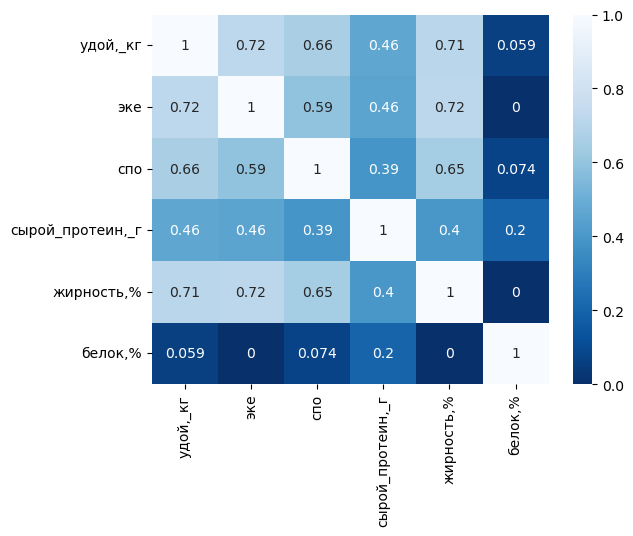

In [66]:
num_cols_names = ['удой,_кг', 'эке', 'спо', 'сырой_протеин,_г', 'жирность,%', 'белок,%']
sns.heatmap(ferma[num_cols_names].phik_matrix(interval_cols=num_cols_names), annot=True, cmap='Blues_r')

<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- сильная корреляциионная взаимосвязь прослеживается между показателем удоя и энергетичечскими кормовыми единицами кормов (0.72), жирности и энергетичечскими кормовыми единицами кормов (0.72)<br>&nbsp;&nbsp;&nbsp;- средняя корреляционная связь между показателями удоя и сахарно-протеиновым соотношением в кормах (0.66), жирности и сахарно-протеиновым соотношением в кормах(0.65)<br>&nbsp;&nbsp;&nbsp;- на белок молока практичечски не влиет ни один из имеющихся количественных показателей, за исключением сырого протеина, с которым можно отметить очень слабую корреляцию.

<font color='Darkblue'>Посмотрим на взаимосвязьколичественных признаков, влияющих на удой (эке, спо и протеин) в разрезе катгориальных признаков

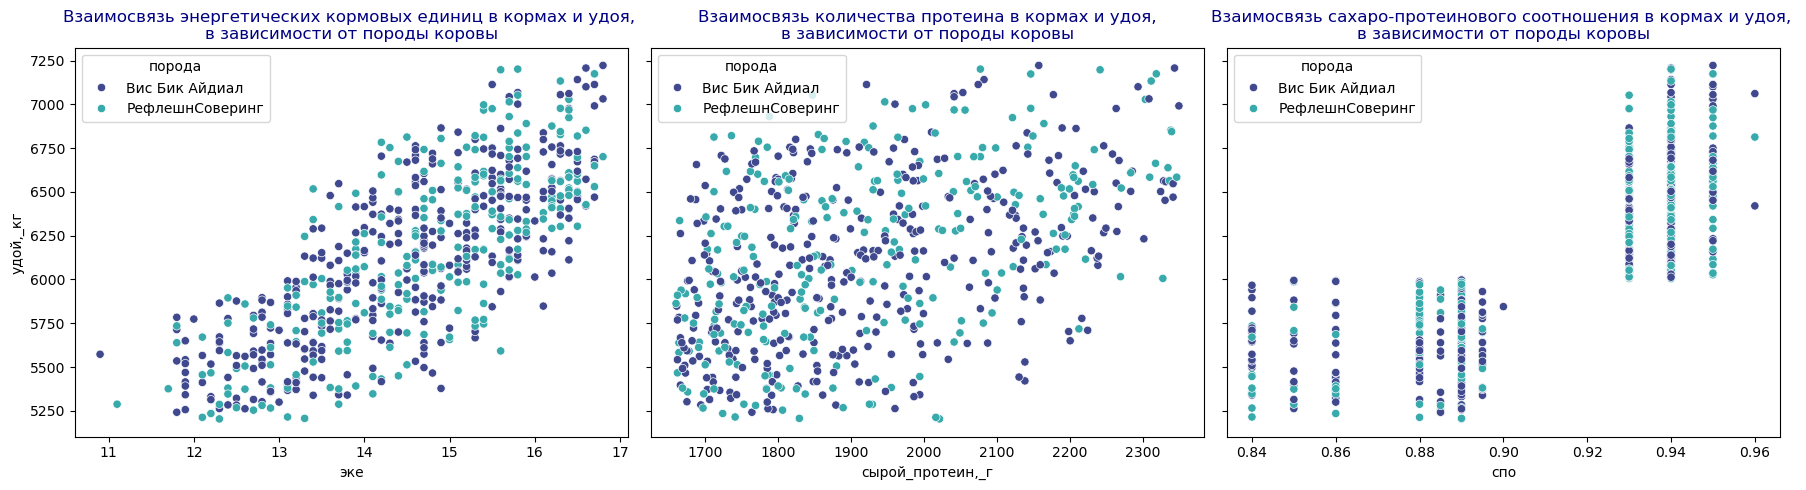

In [69]:
# построим матрицу влияния  на удой в зависимости от породы коровы
fig, axes = plt.subplots(1,3, figsize=(18, 5), sharey=True)

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(data=ferma, x="эке", y="удой,_кг", hue='порода', palette='mako', ax=ax1)
ax1.set_title('Взаимосвязь энергетических кормовых единиц в кормах и удоя, \nв зависимости от породы коровы', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(data=ferma, x="сырой_протеин,_г", y="удой,_кг", hue='порода', palette='mako', ax=ax2)
ax2.set_title('Взаимосвязь количества протеина в кормах и удоя,\nв зависимости от породы коровы', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(data=ferma, x="спо", y="удой,_кг", hue='порода', palette='mako', ax=ax3)
ax3.set_title('Взаимосвязь сахаро-протеинового соотношения в кормах и удоя, \nв зависимости от породы коровы', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

plt.tight_layout()

plt.show()

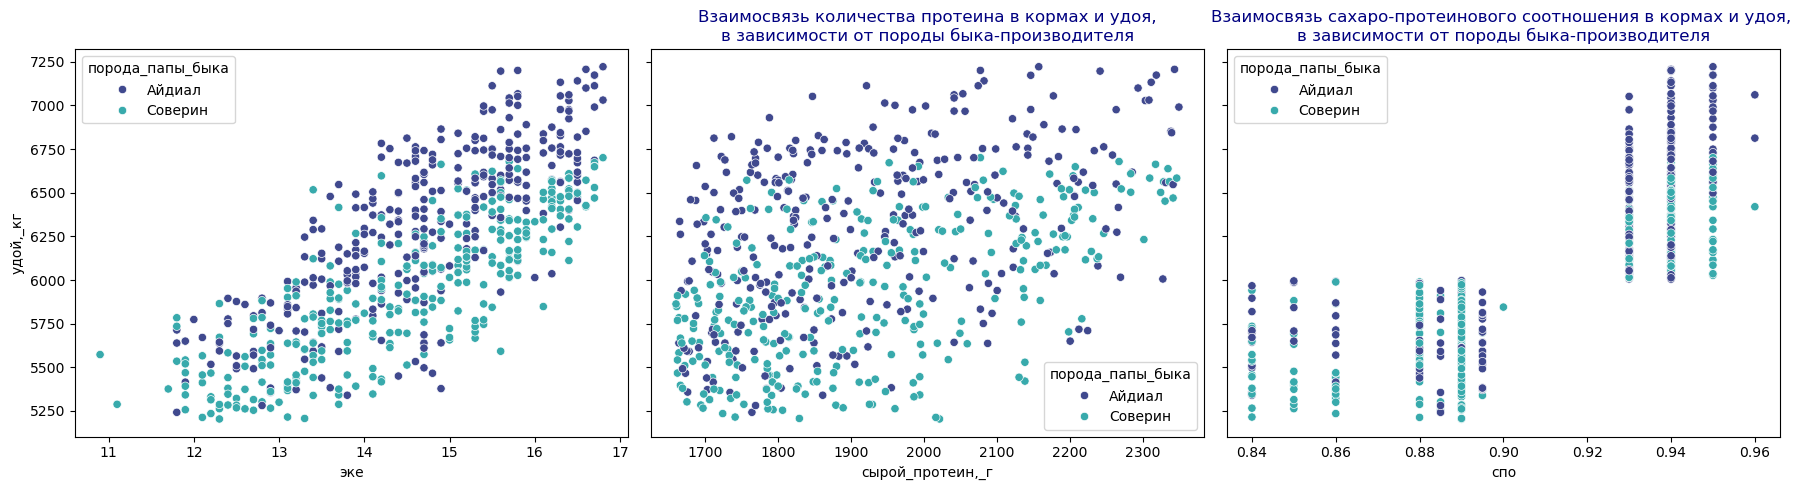

In [70]:
# построим матрицу влияния на удой в зависимости от породы быка-производителя
fig, axes = plt.subplots(1,3, figsize=(18, 5), sharey=True)

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(data=ferma, x="эке", y="удой,_кг", hue='порода_папы_быка', palette='mako', ax=ax1)
ax2.set_title('Взаимосвязь энергетических кормовых единиц в кормах и удоя, \nв зависимости от породы быка-производителя', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(data=ferma, x="сырой_протеин,_г", y="удой,_кг", hue='порода_папы_быка', palette='mako', ax=ax2)
ax2.set_title('Взаимосвязь количества протеина в кормах и удоя,\nв зависимости от породы быка-производителя', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(data=ferma, x="спо", y="удой,_кг", hue='порода_папы_быка', palette='mako', ax=ax3)
ax3.set_title('Взаимосвязь сахаро-протеинового соотношения в кормах и удоя, \nв зависимости от породы быка-производителя', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

plt.tight_layout()

plt.show()

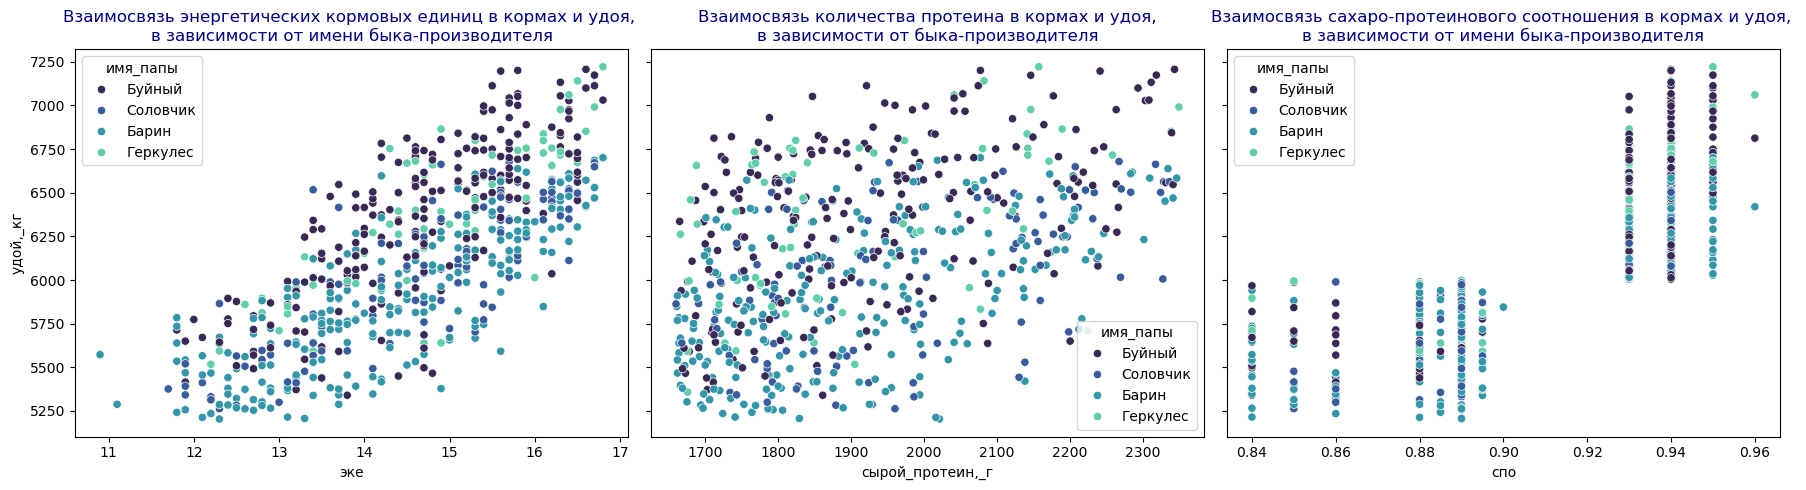

In [71]:
# построим матрицу влияния на удой в зависимости от имени быка-производителя
fig, axes = plt.subplots(1,3, figsize=(18, 5), sharey=True)

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(data=ferma, x="эке", y="удой,_кг", hue='имя_папы', palette='mako', ax=ax1)
ax1.set_title('Взаимосвязь энергетических кормовых единиц в кормах и удоя, \nв зависимости от имени быка-производителя', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(data=ferma, x="сырой_протеин,_г", y="удой,_кг", hue='имя_папы', palette='mako', ax=ax2)
ax2.set_title('Взаимосвязь количества протеина в кормах и удоя,\nв зависимости от быка-производителя', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(data=ferma, x="спо", y="удой,_кг", hue='имя_папы', palette='mako', ax=ax3)
ax3.set_title('Взаимосвязь сахаро-протеинового соотношения в кормах и удоя, \nв зависимости от имени быка-производителя', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

plt.tight_layout()

plt.show()

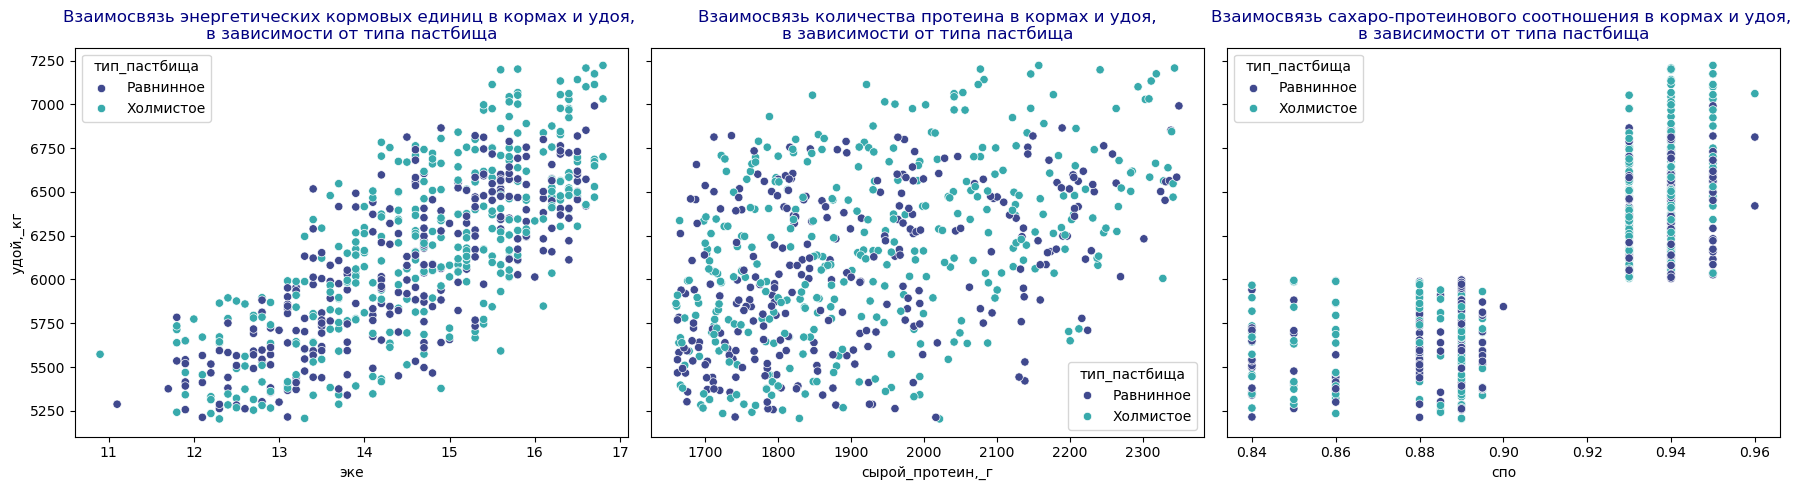

In [72]:
# построим матрицу влияния на удой в зависимости от типа пастбища
fig, axes = plt.subplots(1,3, figsize=(18, 5), sharey=True)

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(data=ferma, x="эке", y="удой,_кг", hue='тип_пастбища', palette='mako', ax=ax1)
ax1.set_title('Взаимосвязь энергетических кормовых единиц в кормах и удоя, \nв зависимости от типа пастбища', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(data=ferma, x="сырой_протеин,_г", y="удой,_кг", hue='тип_пастбища', palette='mako', ax=ax2)
ax2.set_title('Взаимосвязь количества протеина в кормах и удоя,\nв зависимости от типа пастбища', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(data=ferma, x="спо", y="удой,_кг", hue='тип_пастбища', palette='mako', ax=ax3)
ax3.set_title('Взаимосвязь сахаро-протеинового соотношения в кормах и удоя, \nв зависимости от типа пастбища', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

plt.tight_layout()

plt.show()

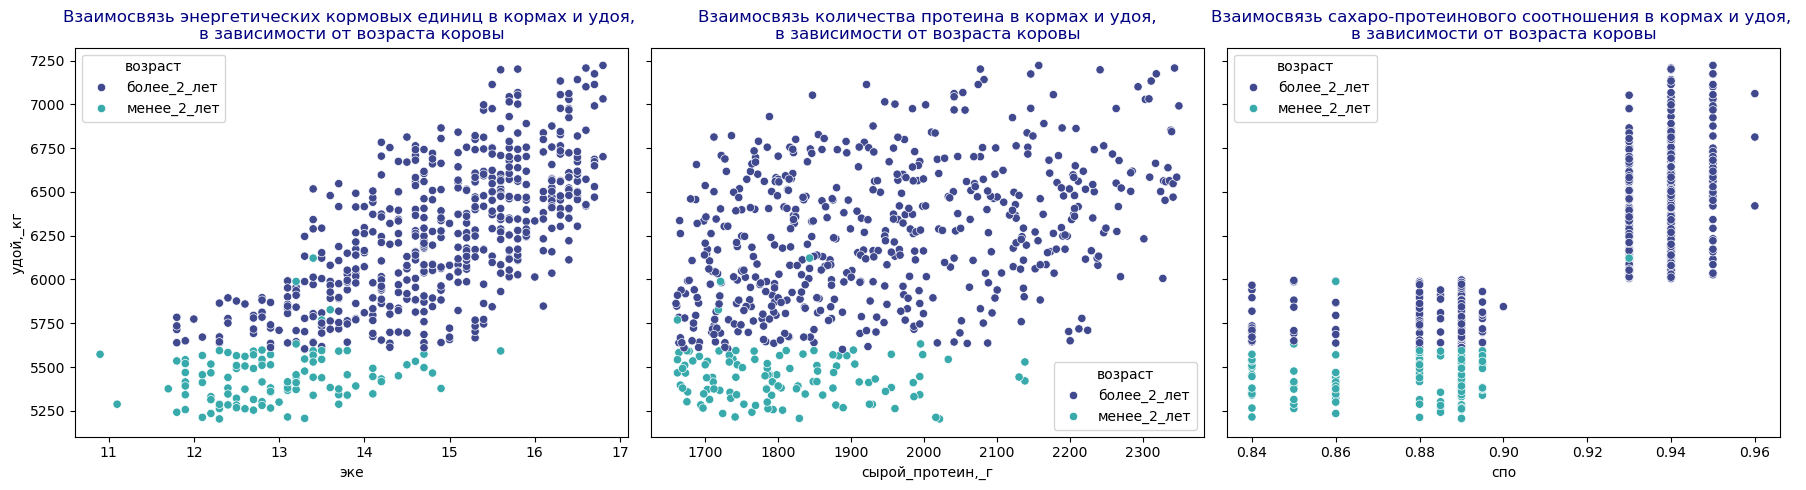

In [73]:
# построим матрицу влияния на удой в зависимости от возрастта коровы
fig, axes = plt.subplots(1,3, figsize=(18, 5), sharey=True)

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(data=ferma, x="эке", y="удой,_кг", hue='возраст', palette='mako', ax=ax1)
ax1.set_title('Взаимосвязь энергетических кормовых единиц в кормах и удоя, \nв зависимости от возраста коровы', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(data=ferma, x="сырой_протеин,_г", y="удой,_кг", hue='возраст', palette='mako', ax=ax2)
ax2.set_title('Взаимосвязь количества протеина в кормах и удоя,\nв зависимости от возраста коровы', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(data=ferma, x="спо", y="удой,_кг", hue='возраст', palette='mako', ax=ax3)
ax3.set_title('Взаимосвязь сахаро-протеинового соотношения в кормах и удоя, \nв зависимости от возраста коровы', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

plt.tight_layout()

plt.show()

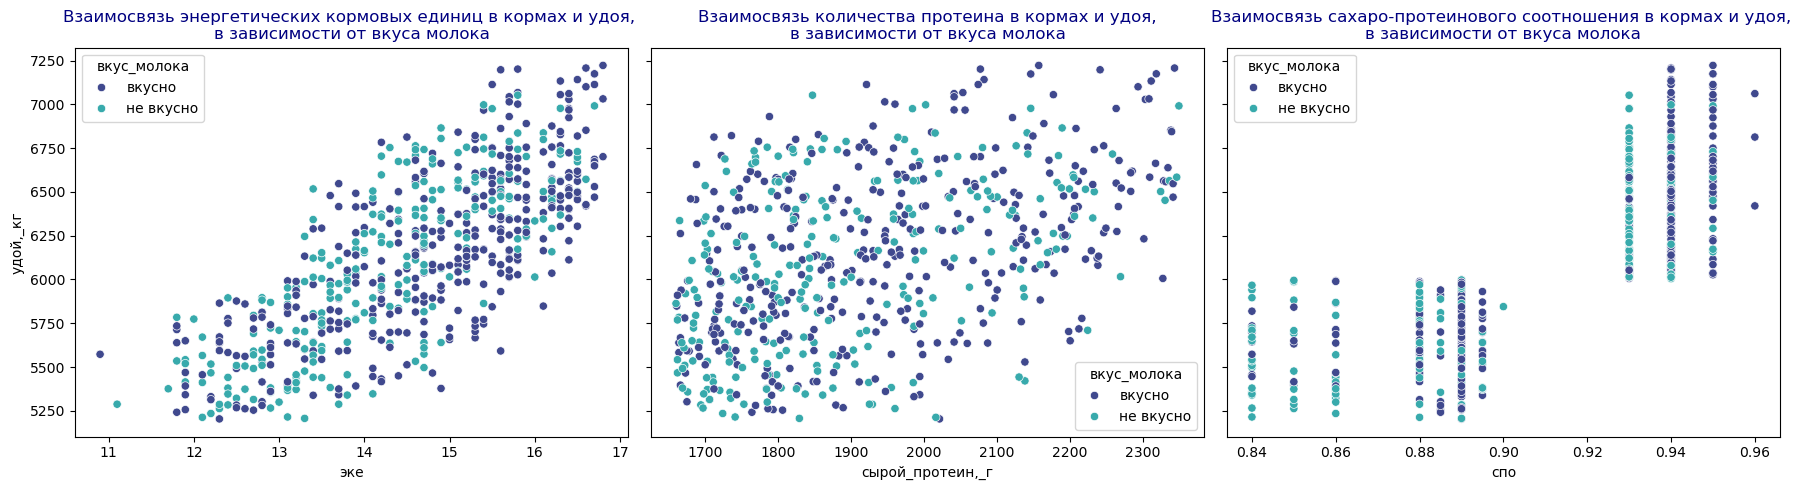

In [74]:
# построим матрицу влияния на удой в зависимости от вкуса молока
fig, axes = plt.subplots(1,3, figsize=(18, 5), sharey=True)

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(data=ferma, x="эке", y="удой,_кг", hue='вкус_молока', palette='mako', ax=ax1)
ax1.set_title('Взаимосвязь энергетических кормовых единиц в кормах и удоя, \nв зависимости от вкуса молока', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(data=ferma, x="сырой_протеин,_г", y="удой,_кг", hue='вкус_молока', palette='mako', ax=ax2)
ax2.set_title('Взаимосвязь количества протеина в кормах и удоя,\nв зависимости от вкуса молока', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(data=ferma, x="спо", y="удой,_кг", hue='вкус_молока', palette='mako', ax=ax3)
ax3.set_title('Взаимосвязь сахаро-протеинового соотношения в кормах и удоя, \nв зависимости от вкуса молока', \
                     fontdict = { 'fontsize': 12, 'color':'navy'})

plt.tight_layout()

plt.show()

### Резюме

<font color='Darkblue'><b>Корреляция количественных показателей хозяйства "Вольный луг"</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;1. сильная корреляциионная взаимосвязь прослеживается между показателем удоя и энергетичечскими кормовыми единицами кормов (0.72), жирности и энергетичечскими кормовыми единицами кормов (0.72)<br>&nbsp;&nbsp;&nbsp;2. средняя корреляционная связь между показателями удоя и сахарно-протеиновым соотношением в кормах (0.66), жирности и сахарно-протеиновым соотношением в кормах(0.65)<br>&nbsp;&nbsp;&nbsp;3. на белок молока практичечски не влиет ни один из имеющихся количественных показателей, за исключением сырого протеина, с которым можно отметить очень слабую корреляцию.

<font color='Darkblue'><b>Влияние показателей поголовья хозяйства "Вольный луг" на удой</b><br>
<font color='Darkblue'><i> По всем графикам видно, что <br>&nbsp;&nbsp;&nbsp;- взаимосвязь показателя эке и удоя можно назвать линейнозависимым, но связь не очень силная, так как облако значений нельзя навать сильно вытянутым <br>&nbsp;&nbsp;&nbsp;- взаимосвязь удоя и показателя содержания сырого протеина слабая, облако значений не сконцентрировано вдоль какой-либо линии <br>&nbsp;&nbsp;&nbsp;- взаимосвязь показателя спо и удоя скорее можно охарктеризовать как кластеры - на графиках видны несколько ярковыраженных кластеров значений
<font color='Darkblue'><b>1. Порода коровы и порода/имя быка производителя</b><br>&nbsp;&nbsp;&nbsp;- удой в равной степени растет с показателем эке по обеим представленным в стаде породам<br>&nbsp;&nbsp;&nbsp;- рост сырого протеина в кормах несущественно влияет на рост удоев вне зависимости от породы коровы<br>&nbsp;&nbsp;&nbsp;- наибольшие удои отмечаются при высоком уровне СПО 0.93-0.95 и в этом кластере превалируют коровы породы РефлешнСоверинг<br>
<font color='Darkblue'><b>2. Порода/имя быка производителя</b><br>&nbsp;&nbsp;&nbsp;- удой стабильно выше у коров, от быков породы Айдиал и с именем Буйный<br>&nbsp;&nbsp;&nbsp;- рост сырого протеина в кормах несущественно влияет на рост удоев вне зависимости от имени быка производителя, однако для породы быков видно, что при одних и тех же значениях протеина удойность коров от быков породы Айдиал выше<br>&nbsp;&nbsp;&nbsp;- - наибольшие удои отмечаются при высоком уровне СПО 0.93-0.95 и в этом кластере заметно превалируют коровы от быков породы Айдиал и по имени Буйный<br>
<font color='Darkblue'><b>3. Возраст коровы</b><br>&nbsp;&nbsp;&nbsp;- поскольку животные старше 2х лет восновном показывают более высокие уровни удоя, то и все выше указанное влияние показателей на удойность у этой группы выше<br>
<font color='Darkblue'><b>4. Тип пастбища коровы</b><br>&nbsp;&nbsp;&nbsp;- у хозяйства доля коров, пасущихся на холмистых пастбищах несколько выше (55.7%) с этим связано, как и в случае с возрастом коров, бОльшая выраженность влияния вышеуказанных факторов на удои: коровы, пасущиеся на Холмистых пастбищах, дают больший прирост удоев, при росте ЭКЕ, протеина и СПО<br>
<font color='Darkblue'><b>5. Вкус молока</b><br>&nbsp;&nbsp;&nbsp;- рост ЭКЕ, приодящий к росту удоев больше прослеживается у невкусного молока<br>&nbsp;&nbsp;&nbsp;- на отметке СПО 0.93 превалирует невкусное молоко, тогда как на отметках 0.94 и 0.95 - вкусное.

<font color='Darkblue'><b><i><u>Общее заключение по взаимовлиянию показателей хозяйства "Вольный луг"</b></i></u><br>
<font color='Darkblue'> <b>1.</b><i> На удйость коровы влияют как порода ее и ее родителей, так и корма, выпас и возраст.<br>Из представленных количественных характеристик кормов можно выделить существенный уровень влияния показателя соотношения сахара и протеинов в кормах (чем выше соотношение, тем выше удойность)</i><br>
<font color='Darkblue'><b>2.</b><i> Вкусовые показатели молока связаны в первую очередь с качеством кормов и химико-биологическими показателями молока, данные о которых предоставлены только в части белков и жиров. Из предоставленных данных можно сделать вывод, что на оценку вкуса в основном влияет содержание жиров, на что в свою очередь влияет ЭКЕ и СПО.

## Регрессия

### Первая модель линейной регрессии

#### Подготовка данных

In [82]:
# выведем названия колонок датасета ferma, чтобы выбрать необходимые признаки для последующего обучения модели
ferma.columns.tolist()

['id',
 'удой,_кг',
 'эке',
 'сырой_протеин,_г',
 'спо',
 'порода',
 'тип_пастбища',
 'порода_папы_быка',
 'жирность,%',
 'белок,%',
 'вкус_молока',
 'возраст',
 'имя_папы']

<font color='Darkblue'> Целевой признак модели - удой <br>
<font color='Darkblue'> Как уже было отмечено выше, на удойность влияют порода (ее и родителей) и возраст, а тажке питание (тип пастбища и показатели кормов). С учетом  этого, признаки, на основании которых будет строиться модель линейной регрессии, предлагается выбрать следующие:<br>`порода` - порода коровы, <br>`порода_папы_быка` - порода быка-производителя,<br>`тип_пастбища` - тип пастбища, на котором пасется корова,<br>`возраст`- возраст животного<br>`спо` - соотношение сахара к протеину в корме коровы,<br>`эке` - показатель питательности корма коровы,<br>`сырой_протеин,_г` - показатель содержания сырого протеина в корме коровы,<br>

In [84]:
#сформируем датасет с выбранными колонками признаков
milk_attributes_columns = ['удой,_кг', 'порода', 'порода_папы_быка', 'тип_пастбища', 'возраст', 'спо', 'эке', 'сырой_протеин,_г']
milk_attributes = ferma.loc[:,milk_attributes_columns]
try:
    display(milk_attributes.head())
    milk_attributes.info()
except:
    print('колонка не найдена')

,"удой,_кг",порода,порода_папы_быка,тип_пастбища,возраст,спо,эке,"сырой_протеин,_г"
0,5863,Вис Бик Айдиал,Айдиал,Равнинное,более_2_лет,0.89,14.20,1743
1,5529,Вис Бик Айдиал,Соверин,Равнинное,менее_2_лет,0.89,12.80,2138
2,5810,РефлешнСоверинг,Соверин,Холмистое,более_2_лет,0.89,14.00,1854
3,5895,РефлешнСоверинг,Айдиал,Холмистое,более_2_лет,0.89,12.40,2012
4,5302,Вис Бик Айдиал,Соверин,Равнинное,менее_2_лет,0.89,12.80,1675


<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   удой,_кг          628 non-null    int64  
 1   порода            628 non-null    object 
 2   порода_папы_быка  628 non-null    object 
 3   тип_пастбища      628 non-null    object 
 4   возраст           628 non-null    object 
 5   спо               628 non-null    float64
 6   эке               628 non-null    float64
 7   сырой_протеин,_г  628 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 44.2+ KB


In [85]:
# сформируем колонку целевого признака и массив входных признаков
X = milk_attributes.drop('удой,_кг', axis=1)
y = milk_attributes['удой,_кг']

In [86]:
# Сформируем тренировочную и тестовую выборки
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
print('\u001b[38;5;19m', 'Размер тренировочной выборки', X_train.shape)
print('\u001b[38;5;19m', 'Размер тестовой выборки', X_test.shape)

 Размер тренировочной выборки (471, 7)
 Размер тестовой выборки (157, 7)


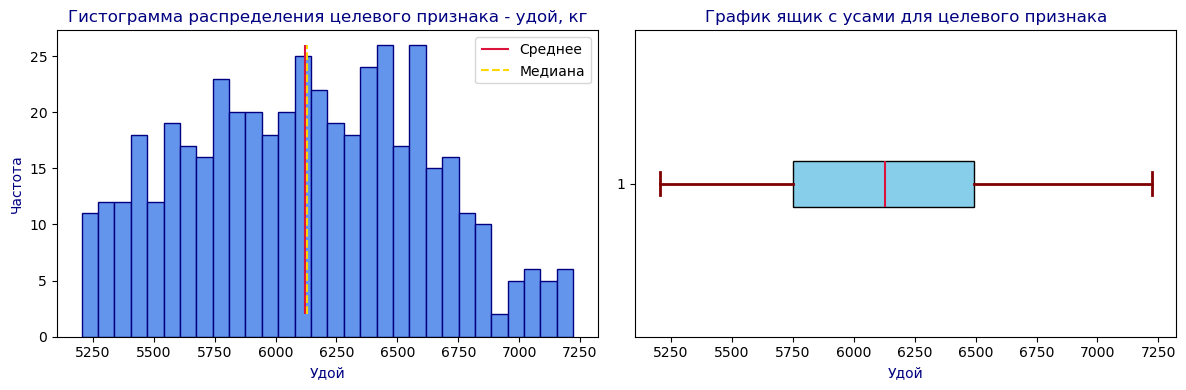

In [87]:
## визуализуализируем распределение целевого признака
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
bins = axes[0].hist(y_train, bins=30, color='cornflowerblue', edgecolor='navy')
axes[0].set_title('Гистограмма распределения целевого признака - удой, кг', color='navy')
axes[0].set_xlabel('Удой', color='navy')
axes[0].set_ylabel('Частота', color='navy')
axes[0].vlines(x=y_train.mean(), colors='crimson', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
axes[0].vlines(x=y_train.median(), colors='gold', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
axes[0].legend()

axes[1].boxplot(y_train, vert=False, patch_artist=True, boxprops = dict(facecolor = "skyblue"), \
                medianprops = dict(color = "crimson", linewidth = 1.5), \
                capprops = dict(color = "maroon", linewidth = 2), whiskerprops = dict(color = "maroon", linewidth = 2))
axes[1].set_title('График ящик с усами для целевого признака', color='navy')
axes[1].set_xlabel('Удой', color='navy')

plt.tight_layout()

plt.show()

#### Кодирование категориальных и масштабирование количественных признаков

In [89]:
# сформирууем список категориальных и количественных признаков
cat_col_names = ['порода', 'порода_папы_быка', 'тип_пастбища', 'возраст']
num_col_names = ['спо', 'эке', 'сырой_протеин,_г']

In [90]:
# проведем кодирование категориальных данных
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [91]:
# проведем масштабирование количественных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

In [92]:
# объединим отмасштабированные и закодированные признаки в один датафрейм
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

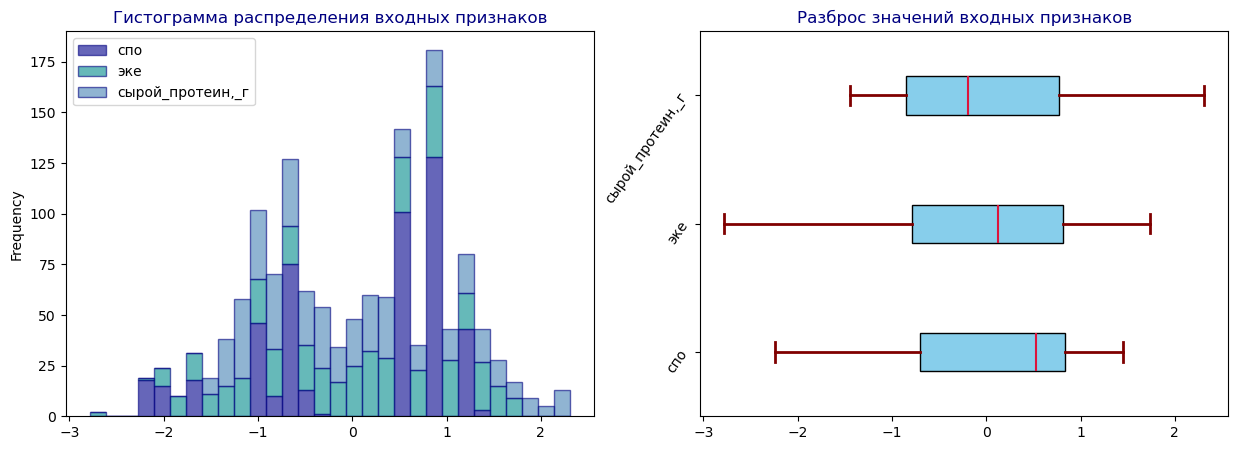

In [93]:
#визуализируем разброс признаков тренировочной выборки
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
X_train[num_col_names].plot(kind='hist', bins=30, stacked=True, color=['darkblue', 'darkcyan', 'steelblue'], edgecolor='navy', alpha=0.6, ax=axes[0])
axes[0].set_title('Гистограмма распределения входных признаков', color='navy')
X_train[num_col_names].plot(kind='box', vert=False, patch_artist=True, boxprops = dict(facecolor = "skyblue"), \
                medianprops = dict(color = "crimson", linewidth = 1.5), \
                capprops = dict(color = "maroon", linewidth = 2), whiskerprops = dict(color = "maroon", linewidth = 2), ax=axes[1], rot=55)
axes[1].set_title('Разброс значений входных признаков', color='navy')
plt.show()

#### Обучение и оценка качества первой модели

In [95]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

In [96]:
# оценим качество модели: посчитаем МАЕ и R²
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('1. cреднее абсолютное значение ошибки модели составляет - {:.2f} кг/год,\n2. кв.корень из среднеквадратической ошибки - {:.2f} кг/год,\n3. коэффициент детерминации - {:.4f}'.format(mae, rmse, r2))

1. cреднее абсолютное значение ошибки модели составляет - 164.24 кг/год,
2. кв.корень из среднеквадратической ошибки - 209.49 кг/год,
3. коэффициент детерминации - 0.7844


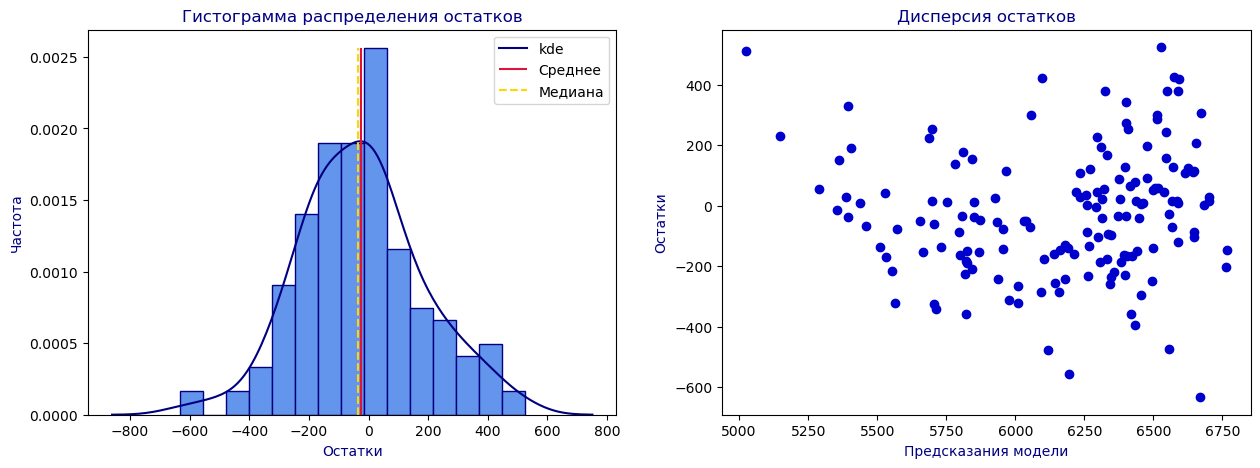

In [97]:
# анализ остатков
# рассчитаем остатки
residuals = y_test - predictions
# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
res = axes[0].hist(residuals, bins=15, density=True, color='cornflowerblue', edgecolor='navy')
sns.kdeplot(residuals, color = 'navy', ax=axes[0], label='kde')
axes[0].set_title('Гистограмма распределения остатков', color='navy')
axes[0].set_xlabel('Остатки', color='navy')
axes[0].set_ylabel('Частота', color='navy')
axes[0].vlines(x=residuals.mean(), colors='crimson', ymin=res[0].min(), ymax=res[0].max(), label='Среднее')
axes[0].vlines(x=residuals.median(), colors='gold', ymin=res[0].min(), ymax=res[0].max(), linestyles='--', label='Медиана')
axes[0].legend()

axes[1].scatter(x=predictions, y=residuals, color='mediumblue')
axes[1].set_xlabel('Предсказания модели', color='navy')
axes[1].set_ylabel('Остатки', color='navy')
axes[1].set_title('Дисперсия остатков', fontdict = {'fontsize': 12, 'color':'navy'})
plt.show()

#### Резюме

<font color='Darkblue'> 1. Модель имеет не высокий коэффициент детерминации - 0.7844 и небольшую среднюю абсолютную ошибку 164.24 кг/год, кв.корень из среднеквадратической ошибки - 209.99 кг/год<br>2. Распределение остатков - симметрично относительно среднего и медианы.<br>3. Дисперсия распределена не равномерно отрезке оси X (от 5.25 до 6.75 тыс. кг/год)<br><i><u>Возможными направлениями доработки признаков для улучшения качества модели - повышения коэффициента детерминации и снижения показателей среднеквадратичной и абсолютной ошибок могут являться:</u><br>&nbsp;&nbsp;&nbsp;- с учетом того, что на диаграмме рассеивания показателя сахаро-протеиного соотношения просмариваются два довольно четких кластера: выше 0.91 и ниже 0.91, - <b><i>изменение показателя `сахаро-протеинового соотношения` с количественного на категориальный признак</b></i><br>&nbsp;&nbsp;&nbsp;- для исключения нелинейности связи между входным и целевым признаками - <b><i>возведение в квадрат показателя `эке` для исключения нелинейности

### Вторая модель линейной регрессии

#### Подготовка данных

<font color='Darkblue'> Целевой признак модели - удой <br>
<font color='Darkblue'> С учетом выводов по результатам оценки качества первой модели, признаки, на основании которых будет строиться модель линейной регрессии, предлагается выбрать следующие:<br>`порода` - порода коровы, <br>`порода_папы_быка` - порода быка-производителя,<br>`тип_пастбища` - тип пастбища, на котором пасется корова,<br>`возраст`- возраст животного<br>`спо_кат` - переведенный категориальный показатель соотношения сахара к протеину в корме коровы: выше или ниже 0.91 <br>`эке_кв` - возведенный в квадрат показатель питательности корма коровы,<br>`сырой_протеин,_г` - показатель содержания сырого протеина в корме коровы,<br>

In [103]:
# изменим показатель СПО на категориальный: все что выше порога 0.91 - 1, ниже порога - 0
X['спо_кат'] = X['спо'].apply(lambda x : 1 if x>0.91 else 0)
X['спо_кат'].unique()

array([0, 1], dtype=int64)

In [104]:
# создадим колонку с новым признаком - эке**2
X['эке_кв'] = X['эке']**2
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   порода            628 non-null    object 
 1   порода_папы_быка  628 non-null    object 
 2   тип_пастбища      628 non-null    object 
 3   возраст           628 non-null    object 
 4   спо               628 non-null    float64
 5   эке               628 non-null    float64
 6   сырой_протеин,_г  628 non-null    int64  
 7   спо_кат           628 non-null    int64  
 8   эке_кв            628 non-null    float64
dtypes: float64(3), int64(2), object(4)
memory usage: 49.1+ KB


In [105]:
## создадим новый датафрейм для второй модели
X_update = X.drop(['спо', 'эке'], axis=1)
X_update.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   порода            628 non-null    object 
 1   порода_папы_быка  628 non-null    object 
 2   тип_пастбища      628 non-null    object 
 3   возраст           628 non-null    object 
 4   сырой_протеин,_г  628 non-null    int64  
 5   спо_кат           628 non-null    int64  
 6   эке_кв            628 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 39.2+ KB


In [106]:
# Сформируем тренировочную и тестовую выборки
RANDOM_STATE = 42
X_train_update, X_test_update, y_train, y_test = train_test_split(X_update, y, random_state=RANDOM_STATE)
print('\u001b[38;5;19m', 'Размер тренировочной выборки', X_train_update.shape, '\u001b[0m')
print('\u001b[38;5;19m', 'Размер тестовой выборки', X_test_update.shape, '\u001b[0m')

 Размер тренировочной выборки (471, 7) 
 Размер тестовой выборки (157, 7) 


In [107]:
X_train_update.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471 entries, 508 to 103
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   порода            471 non-null    object 
 1   порода_папы_быка  471 non-null    object 
 2   тип_пастбища      471 non-null    object 
 3   возраст           471 non-null    object 
 4   сырой_протеин,_г  471 non-null    int64  
 5   спо_кат           471 non-null    int64  
 6   эке_кв            471 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 29.4+ KB


#### Кодировние категориальных и масштабирование количественных данных

In [109]:
# сформирууем список категориальных и количественных признаков
cat_col_names_update = ['порода','порода_папы_быка','тип_пастбища','возраст','спо_кат']
num_col_names_update = ['эке_кв', 'сырой_протеин,_г']

In [110]:
# проведем кодирование категориальных признаков
# проведем кодирование категориальных данных
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe_update = encoder.fit_transform(X_train_update[cat_col_names_update])
X_test_ohe_update = encoder.transform(X_test_update[cat_col_names_update])
encoder_col_names_update = encoder.get_feature_names_out()
X_train_ohe_update = pd.DataFrame(X_train_ohe_update, columns=encoder_col_names_update)
X_test_ohe_update = pd.DataFrame(X_test_ohe_update, columns=encoder_col_names_update)

In [111]:
# проведем масштабирование количественных данных
scaler = StandardScaler()
X_train_scaled_update = scaler.fit_transform(X_train_update[num_col_names_update])
X_test_scaled_update = scaler.transform(X_test_update[num_col_names_update])

X_train_scaled_update = pd.DataFrame(X_train_scaled_update, columns=num_col_names_update)
X_test_scaled_update = pd.DataFrame(X_test_scaled_update, columns=num_col_names_update)

In [112]:
# объединим отмасштабированные и закодированные признаки в один датафрейм
X_train_update = pd.concat([X_train_ohe_update, X_train_scaled_update], axis=1)
X_test_update = pd.concat([X_test_ohe_update, X_test_scaled_update], axis=1)

#### Обучение и оценка качества второй модели

In [114]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train_update, y_train)
predictions_update = model_lr.predict(X_test_update)

In [115]:
# оценим качество модели: посчитаем МАЕ и R²
mae_update = mean_absolute_error(y_test, predictions_update)
r2_update = r2_score(y_test, predictions_update)
rmse_update = np.sqrt(mean_squared_error(y_test, predictions_update))
print('\u001b[38;5;19m', '1. cреднее абсолютное значение ошибки модели составляет - {:.2f} кг/год,\n2. кв.корень из среднеквадратической ошибки - {:.2f} кг/год,\n3. коэффициент детерминации - {:.4f}'.format(mae_update, rmse_update, r2_update), '\u001b[0m')

 1. cреднее абсолютное значение ошибки модели составляет - 149.04 кг/год,
2. кв.корень из среднеквадратической ошибки - 192.43 кг/год,
3. коэффициент детерминации - 0.8181 


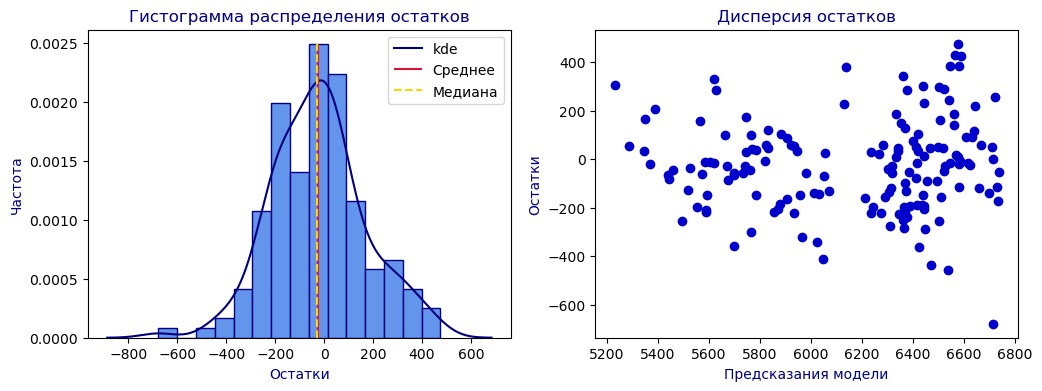

In [116]:
# анализ остатков
# рассчитаем остатки
residuals_update = y_test - predictions_update
# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
res_update = axes[0].hist(residuals_update, bins=15, density=True, color='cornflowerblue', edgecolor='navy')
sns.kdeplot(residuals_update, color = 'navy', ax=axes[0], label='kde')
axes[0].set_title('Гистограмма распределения остатков', color='navy')
axes[0].set_xlabel('Остатки', color='navy')
axes[0].set_ylabel('Частота', color='navy')
axes[0].vlines(x=residuals_update.mean(), colors='crimson', ymin=res_update[0].min(), ymax=res_update[0].max(), label='Среднее')
axes[0].vlines(x=residuals_update.median(), colors='gold', ymin=res_update[0].min(), ymax=res_update[0].max(), linestyles='--', label='Медиана')
axes[0].legend()

axes[1].scatter(x=predictions_update, y=residuals_update, color='mediumblue')
axes[1].set_xlabel('Предсказания модели', color='navy')
axes[1].set_ylabel('Остатки', color='navy')
axes[1].set_title('Дисперсия остатков', fontdict = {'fontsize': 12, 'color':'navy'})
plt.show()

#### Резюме

<font color='Darkblue'> 1. Модель имеет не высокий коэффициент детерминации - 0.8181 и небольшую среднюю абсолютную ошибку 149.04 кг/год, кв.корень из среднеквадратической ошибки - 192.43 кг/год<br>2. Распределение остатков - симметрично относительно среднего и медианы.<br>3. Дисперсия распределена не очень равномерно отрезке оси X (от 5.3 до 6.75 тыс. кг/год)<br><i><u>Возможными направлениями улучшения качества модели - может являться использование категориального признака `имя_папы` вместо `породы быка`

### Третья модель линейной регрессии

#### Подготовка данных

<font color='Darkblue'> Целевой признак модели - удой <br>
<font color='Darkblue'> С учетом выводов по результатам оценки качества второй модели, признаки, на основании которых будет строиться модель линейной регрессии, предлагается выбрать следующие:<br>`порода` - порода коровы, <br>`имя_папы` - имя быка-производителя,<br>`тип_пастбища` - тип пастбища, на котором пасется корова,<br>`возраст`- возраст животного<br>`спо_кат` - переведенный категориальный показатель соотношения сахара к протеину в корме коровы: выше или ниже 0.91 <br>`эке_кв` - возведенный в квадрат показатель питательности корма коровы,<br>`сырой_протеин,_г` - показатель содержания сырого протеина в корме коровы,<br>

In [122]:
# создадим колонку с новым признаком - эке**2
X_update_2 = X_update.drop('порода_папы_быка', axis=1)
X_update_2['имя_папы'] = ferma['имя_папы']
X_update_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   порода            628 non-null    object 
 1   тип_пастбища      628 non-null    object 
 2   возраст           628 non-null    object 
 3   сырой_протеин,_г  628 non-null    int64  
 4   спо_кат           628 non-null    int64  
 5   эке_кв            628 non-null    float64
 6   имя_папы          628 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 39.2+ KB


In [123]:
# Сформируем тренировочную и тестовую выборки
RANDOM_STATE = 42
X_train_update_2, X_test_update_2, y_train, y_test = train_test_split(X_update_2, y, random_state=RANDOM_STATE)
print('\u001b[38;5;19m', 'Размер тренировочной выборки', X_train_update_2.shape, '\u001b[0m')
print('\u001b[38;5;19m', 'Размер тестовой выборки', X_test_update_2.shape, '\u001b[0m')

 Размер тренировочной выборки (471, 7) 
 Размер тестовой выборки (157, 7) 


In [124]:
X_train_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   порода_РефлешнСоверинг    471 non-null    float64
 1   порода_папы_быка_Соверин  471 non-null    float64
 2   тип_пастбища_Холмистое    471 non-null    float64
 3   возраст_менее_2_лет       471 non-null    float64
 4   спо_кат_1                 471 non-null    float64
 5   эке_кв                    471 non-null    float64
 6   сырой_протеин,_г          471 non-null    float64
dtypes: float64(7)
memory usage: 25.9 KB


#### Кодирование категориальных и масштабирование количественных признаков

In [126]:
# сформирууем список категориальных и количественных признаков
cat_col_names_update_2 = ['порода','имя_папы','тип_пастбища','возраст','спо_кат']
num_col_names_update_2 = ['эке_кв', 'сырой_протеин,_г']

In [127]:
# проведем кодирование категориальных данных
encoder_1 = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe_update_2 = encoder_1.fit_transform(X_train_update_2[cat_col_names_update_2])
X_test_ohe_update_2 = encoder_1.transform(X_test_update_2[cat_col_names_update_2])
encoder_col_names_update_2 = encoder_1.get_feature_names_out()
X_train_ohe_update_2 = pd.DataFrame(X_train_ohe_update_2, columns=encoder_col_names_update_2)
X_test_ohe_update_2 = pd.DataFrame(X_test_ohe_update_2, columns=encoder_col_names_update_2)

In [128]:
# проведем масштабирование количественных данных
scaler_1 = StandardScaler()
X_train_scaled_update_2 = scaler_1.fit_transform(X_train_update_2[num_col_names_update_2])
X_test_scaled_update_2 = scaler_1.transform(X_test_update_2[num_col_names_update_2])

X_train_scaled_update_2 = pd.DataFrame(X_train_scaled_update_2, columns=num_col_names_update_2)
X_test_scaled_update_2 = pd.DataFrame(X_test_scaled_update_2, columns=num_col_names_update_2)

In [129]:
# объединим отмасштабированные и закодированные признаки в один датафрейм
X_train_update_2 = pd.concat([X_train_ohe_update_2, X_train_scaled_update_2], axis=1)
X_test_update_2 = pd.concat([X_test_ohe_update_2, X_test_scaled_update_2], axis=1)

#### Обучение и оценка качества третьей модели

In [131]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train_update_2, y_train)
predictions_update_2 = model_lr.predict(X_test_update_2)

In [132]:
# оценим качество модели: посчитаем МАЕ и R²
mae_update_2 = mean_absolute_error(y_test, predictions_update_2)
r2_update_2 = r2_score(y_test, predictions_update_2)
rmse_update_2 = np.sqrt(mean_squared_error(y_test, predictions_update))
print('\u001b[38;5;19m', '1. cреднее абсолютное значение ошибки модели составляет - {:.2f} кг/год,\n2. кв.корень из среднеквадратической ошибки - {:.2f} кг/год,\n3. коэффициент детерминации - {:.4f}'.format(mae_update_2, rmse_update_2, r2_update_2), '\u001b[0m')

 1. cреднее абсолютное значение ошибки модели составляет - 144.64 кг/год,
2. кв.корень из среднеквадратической ошибки - 192.43 кг/год,
3. коэффициент детерминации - 0.8265 


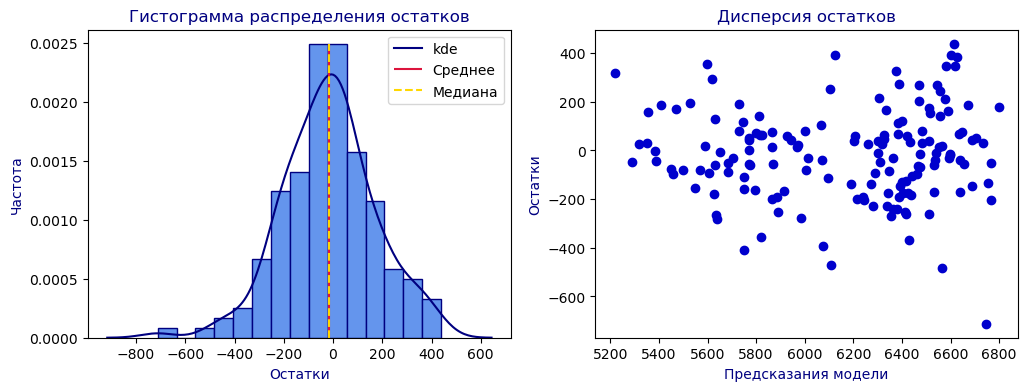

In [133]:
# анализ остатков
# рассчитаем остатки
residuals_update_2 = y_test - predictions_update_2
# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
res_update_2 = axes[0].hist(residuals_update_2, bins=15, density=True, color='cornflowerblue', edgecolor='navy')
sns.kdeplot(residuals_update_2, color = 'navy', ax=axes[0], label='kde')
axes[0].set_title('Гистограмма распределения остатков', color='navy')
axes[0].set_xlabel('Остатки', color='navy')
axes[0].set_ylabel('Частота', color='navy')
axes[0].vlines(x=residuals_update_2.mean(), colors='crimson', ymin=res_update_2[0].min(), ymax=res_update_2[0].max(), label='Среднее')
axes[0].vlines(x=residuals_update_2.median(), colors='gold', ymin=res_update_2[0].min(), ymax=res_update_2[0].max(), linestyles='--', label='Медиана')
axes[0].legend()

axes[1].scatter(x=predictions_update_2, y=residuals_update_2, color='mediumblue')
axes[1].set_xlabel('Предсказания модели', color='navy')
axes[1].set_ylabel('Остатки', color='navy')
axes[1].set_title('Дисперсия остатков', fontdict = {'fontsize': 12, 'color':'navy'})
plt.show()

#### Резюме

<font color='Darkblue'> 1. Модель имеет более высокий чем у первой модели коэффициент детерминации - 0.8265 и а также меньшие, чем у первой модели небольшую среднюю абсолютную ошибку 144.64 кг/год и кв.корень из среднеквадратичесойю ошибки - 192.43 кг/год<br>2. Распределение остатков - симметрично относительно среднего и медианы.<br>3. Дисперсия чуть более равномерна, чем у второй модели<br><u><i>Третья модель регрессии показала немного лучший результат, чем вторая

### Выбор лучшей модели и доверительный интервал

In [137]:
# сформируем таблицу с результатами оценки качества моделей
models_results = {'model': ['model_1', 'model_2', 'model_3'], \
                  'rmse': [rmse, rmse_update, rmse_update_2], \
                  'mae': [mae, mae_update, mae_update_2], \
                  'r2': [r2, r2_update, r2_update_2]} 
models_res = pd.DataFrame(models_results) 
models_res

,model,rmse,mae,r2
0,model_1,209.49,164.24,0.78
1,model_2,192.43,149.04,0.82
2,model_3,192.43,144.64,0.83


<font color='Darkblue'> Из таблицы следует, что третья модель (построенная с реклассификацией СПО в категориальный признак и возведением в квадрат показателя ЭКЕ и учетом имени быка, вместо породы быка) показывает лучший результат. Поэтому <b >выберем третью модель для дальнейшей работы и построения доверительного интервала</b><br> <br><font color='Darkblue'><b>Доверительный интервал</b> - диапазон значений удоя, который, вероятно, содержит истинный диапазон значений для среднего значения прогноза удоя: <b><i>если мы рассчитаем 95% доверительный интервал для среднего показателя прогноза удоя, это означает что мы на 95% уверены, что истинное среднее значение для обанружения находится в пределах этого интервала 

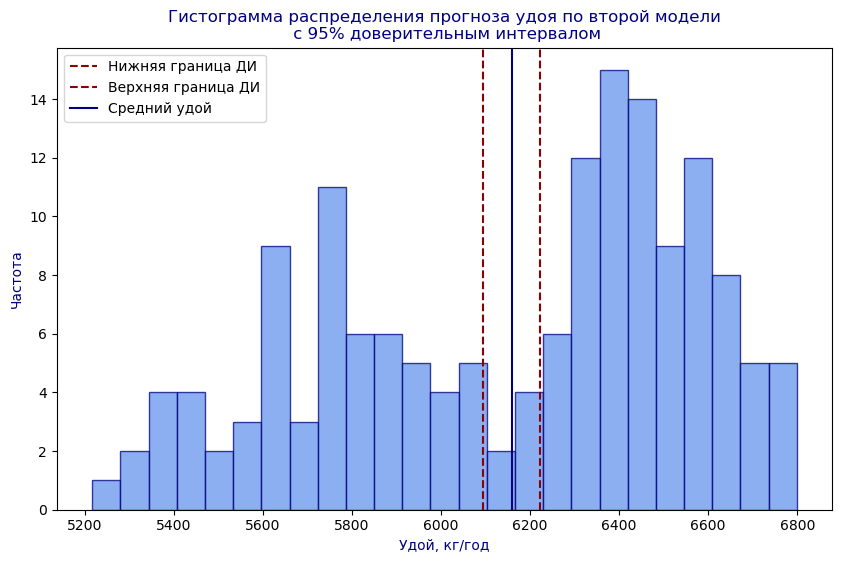

 95% доверительный интервал по удою находится в пределах от 6094.81 кг/год до 6222.74 кг/год. 
Средний показатель удоя составляет 6158.77 кг/год 


In [139]:
# Рассчитаем статистики по прогнозу удоя выбранной второй модели
predictions_update_2_mean = np.mean(predictions_update_2)
predictions_update_2_std = np.std(predictions_update_2)
predictions_update_2_size = len(predictions_update_2)

# ДИ
confidence_level = 0.95

# Расчет z-score для ДИ 95%
z_score = 1.96 

# Границы "доверия"
margin_of_error = z_score * (predictions_update_2_std / np.sqrt(predictions_update_2_size))

# Расчет доверительного интервала
confidence_interval = (predictions_update_2_mean - margin_of_error,predictions_update_2_mean + margin_of_error)

# Визуализация распределения прогноза удоя по второй модели с доверительным интервалом
plt.figure(figsize=(10, 6))
plt.hist(predictions_update_2, bins=25, alpha=0.75, color='cornflowerblue', edgecolor='navy')
plt.axvline(confidence_interval[0], color='darkred', linestyle='--', label='Нижняя граница ДИ')
plt.axvline(confidence_interval[1], color='darkred', linestyle='--', label='Верхняя граница ДИ')
plt.axvline(predictions_update_2_mean, color='navy', linestyle='-', label='Средний удой')
plt.xlabel('Удой, кг/год', color='navy')
plt.ylabel('Частота', color='navy')
plt.title('Гистограмма распределения прогноза удоя по второй модели\n с 95% доверительным интервалом', color='navy')
plt.legend()
plt.show()

print('\u001b[38;5;19m', '95% доверительный интервал по удою находится в пределах от {:.2f} кг/год до {:.2f} кг/год. \nСредний показатель удоя составляет {:.2f} кг/год'.format(confidence_interval[0], confidence_interval[1], predictions_update_2_mean), '\u001b[0m')

<font color='Darkblue'><b><i> Комментарий

<font color='Darkblue'>✔️ В результате построения моделей линейной регрессии исходя из данных фермерского хозяйства "Вольный луг" о поголовье и кормах , наилучшими образом показала себя модель, учитывающая следующие признаки:<br>&nbsp;&nbsp;&nbsp;`порода` - порода коровы, <br>&nbsp;&nbsp;&nbsp;`имя_папы` - конкретный бык-производитель коровы,<br>&nbsp;&nbsp;&nbsp;`тип_пастбища` - тип пастбища, на котором пасется корова,<br>&nbsp;&nbsp;&nbsp;`возраст`- возраст животного<br>&nbsp;&nbsp;&nbsp;`спо` - соотношение сахара к протеину в корме коровы, переведенное в категориальный признак - выше/ниже 0.91<br>&nbsp;&nbsp;&nbsp;`эке_кв` - показатель питательности корма коровы возведенный в квадрат<br>&nbsp;&nbsp;&nbsp;`сырой_протеин,_г` - показатель содержания сырого протеина в корме коровы<br>✔️ Коэффициент детерминации модели составляет - 0.83 и среднюю абсолютную ошибку 144.64 кг/год <br>✔️  95% доверительный интервал по удою находится в пределах от 6092.81 кг/год до 6222.74 кг/год. <br>Средний показатель удоя составляет 6158.77 кг/год

### Прогноз удойности для коров ЭкоФермы

#### Подготовка данных

<font color='Darkblue'>Для формирования прогноза удойности поголовья Экофермы необходимо, чтобы количество признаков совпадало с количеством признаков в модели прогноза удойности построенной по данным о поголовье хозяйства "Вольный луг"

In [145]:
print('\u001b[38;5;19m', 'Датасет о поголовье ЭкоФермы, содержит {} колонок: '.format(len(cow_buy.columns.values)), '\u001b[0m')
for name in list(cow_buy.columns.values):
    print('\u001b[38;5;19m', '- ', name, '\u001b[0m')
print('-'*100)
print('\u001b[38;5;19m', 'Датасет данных модели о поголовье Вольный луг, содержит {} колонок: '.format(len(X_update_2.columns.values)), '\u001b[0m')
for name in list(X_update_2.columns.values):
    print('\u001b[38;5;19m', '- ', name, '\u001b[0m')

 Датасет о поголовье ЭкоФермы, содержит 7 колонок:  
 -  порода 
 -  тип_пастбища 
 -  порода_папы_быка 
 -  имя_папы 
 -  текущая_жирность,% 
 -  текущий_уровень_белок,% 
 -  возраст 
----------------------------------------------------------------------------------------------------
 Датасет данных модели о поголовье Вольный луг, содержит 7 колонок:  
 -  порода 
 -  тип_пастбища 
 -  возраст 
 -  сырой_протеин,_г 
 -  спо_кат 
 -  эке_кв 
 -  имя_папы 


<font color='Darkblue'> Из вышеприведенных данных видно, что для прогноза удоя из датасета о поголовье ЭкоФермы надо исключить данные о породе быка `порода_папы_быка`, о молоке `текущая жирность,%` и `текущий_уровень_белок%`, и добавить колонки `спо_кат`, `сырой_протеин,_г` и `эке_кв`

In [147]:
# добавим симулированные дополнительные данные об эке, сыром протеине и сахаро_протеиновом соотношении в датасет о поголовье ЭкоФермы
cow_buy['эке_кв'] , cow_buy['спо'] , cow_buy['сырой_протеин,_г'] = (ferma['эке'].mean()*1.05)**2, \
                                                                ferma['спо'].mean()*1.05, \
                                                                ferma['сырой_протеин,_г'].mean()*1.05
cow_buy['спо_кат'] = cow_buy['спо'].apply(lambda x : 1 if x>(0.91*1.05) else 0)
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке_кв,спо,"сырой_протеин,_г",спо_кат
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,233.36,0.96,"2,019.95",1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет,233.36,0.96,"2,019.95",1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.07,более_2_лет,233.36,0.96,"2,019.95",1
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,233.36,0.96,"2,019.95",1
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,233.36,0.96,"2,019.95",1


In [148]:
## создадим новый датафрейм для второй модели и разместим колонки в том же порядке, что и в датасете ferma
X_cows = cow_buy.drop(['порода_папы_быка', 'текущая_жирность,%', 'текущий_уровень_белок,%', 'спо'], axis=1)
cow_cols = ['порода', 'тип_пастбища','возраст', 'сырой_протеин,_г', 'спо_кат', 'эке_кв', 'имя_папы']
X_cows = X_cows[cow_cols]
X_cows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   порода            20 non-null     object 
 1   тип_пастбища      20 non-null     object 
 2   возраст           20 non-null     object 
 3   сырой_протеин,_г  20 non-null     float64
 4   спо_кат           20 non-null     int64  
 5   эке_кв            20 non-null     float64
 6   имя_папы          20 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ KB


In [149]:
# Перед кодированием проверим сопоставимость значений в категориальных колонках
column_list = ['порода', 'тип_пастбища', 'возраст', 'спо_кат', 'имя_папы']
print('\u001b[38;5;19m', 'Перечень уникальных значений в колонках датасета поголовье хозяйства Вольный луг')
for column_name in column_list:
    print('\u001b[38;5;19m', column_name, X_update_2[column_name].unique(), '\u001b[0m')
print('-'*100)
print('\u001b[38;5;19m', 'Перечень уникальных значений в колонках датасета о поголовье ЭкоФермы')
for column_name in column_list:
    print('\u001b[38;5;19m', column_name, X_cows[column_name].unique(), '\u001b[0m')

 Перечень уникальных значений в колонках датасета поголовье хозяйства Вольный луг
 порода ['Вис Бик Айдиал' 'РефлешнСоверинг'] 
 тип_пастбища ['Равнинное' 'Холмистое'] 
 возраст ['более_2_лет' 'менее_2_лет'] 
 спо_кат [0 1] 
 имя_папы ['Буйный' 'Соловчик' 'Барин' 'Геркулес'] 
----------------------------------------------------------------------------------------------------
 Перечень уникальных значений в колонках датасета о поголовье ЭкоФермы
 порода ['Вис Бик Айдиал' 'РефлешнСоверинг'] 
 тип_пастбища ['Холмистое' 'Равнинное'] 
 возраст ['более_2_лет' 'менее_2_лет'] 
 спо_кат [1] 
 имя_папы ['Геркулес' 'Буйный' 'Барин' 'Соловчик'] 


#### Кодировние категориальных и масштабирование количественных данных

In [151]:
cat_col_names_update = ['порода', 'имя_папы', 'тип_пастбища', 'возраст', 'спо_кат']
num_col_names_update = ['эке_кв', 'сырой_протеин,_г']

In [152]:
# проведем кодирование категориальных признаков Экофермы
X_eco_ohe = encoder_1.transform(X_cows[cat_col_names_update])
X_eco_ohe = pd.DataFrame(X_eco_ohe, columns=encoder_col_names_update_2)

In [153]:
# проведем масштабирование количественных признаков данных Экофермы
X_eco_scaled = scaler_1.transform(X_cows[num_col_names_update])
X_eco_scaled = pd.DataFrame(X_eco_scaled, columns=num_col_names_update)

In [154]:
# объединим отмасштабированные и закодированные признаки в один датафрейм
X_eco = pd.concat([X_eco_ohe, X_eco_scaled], axis=1)

#### Прогноз удоя коров ЭкоФермы

In [156]:
predictions_milk_eco = model_lr.predict(X_eco)
cow_buy['удой,_кг'] = predictions_milk_eco
cow_buy.describe()

,"текущая_жирность,%","текущий_уровень_белок,%",эке_кв,спо,"сырой_протеин,_г",спо_кат,"удой,_кг"
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00
mean,3.58,3.07,233.36,0.96,"2,019.95",1.00,"6,443.07"
std,0.13,0.01,0.00,0.00,0.00,0.00,145.78
min,3.34,3.05,233.36,0.96,"2,019.95",1.00,"6,121.39"
25%,3.51,3.06,233.36,0.96,"2,019.95",1.00,"6,337.70"
50%,3.59,3.07,233.36,0.96,"2,019.95",1.00,"6,463.15"
75%,3.65,3.08,233.36,0.96,"2,019.95",1.00,"6,578.64"
max,3.77,3.08,233.36,0.96,"2,019.95",1.00,"6,608.44"


#### Резюме

<font color='Darkblue'>По итогу <b>прогноза удоя у поголовья ЭкоФермы</b> на основе выбранной модели линейной регресии можно сказать:<br>&nbsp;&nbsp;&nbsp;- <b>средний уровень удоя коров составялет 6,443.07 кг/год</b>, что в целом не сильно отличается от медианного показателя - 6,463.15 кг/год<br>&nbsp;&nbsp;&nbsp;- <b>максимальный уровень удоя в поголовье составляет 6,608.44 кг/год </b><br>&nbsp;&nbsp;&nbsp;- минимальный уровень удоя в поголовье составляет 6,121.39 кг/год

## Классификация

### Подготовка данных для модели логистической регрессии

In [161]:
display(ferma.describe(include=[object]))
ferma.describe()

,порода,тип_пастбища,порода_папы_быка,вкус_молока,возраст,имя_папы
count,628,628,628,628,628,628
unique,2,2,2,2,2,4
top,Вис Бик Айдиал,Холмистое,Айдиал,вкусно,более_2_лет,Барин
freq,372,350,317,370,518,240


,id,"удой,_кг",эке,"сырой_протеин,_г",спо,"жирность,%","белок,%"
count,628.00,628.00,628.00,628.00,628.00,628.00,628.00
mean,315.47,"6,125.97",14.55,"1,923.76",0.91,3.60,3.08
std,181.48,475.86,1.30,182.83,0.03,0.17,0.00
min,1.00,"5,204.00",10.90,"1,660.00",0.84,2.99,3.07
25%,158.75,"5,749.75",13.50,"1,771.75",0.89,3.59,3.07
50%,315.50,"6,132.50",14.70,"1,888.00",0.93,3.65,3.08
75%,472.25,"6,501.00",15.60,"2,062.25",0.94,3.72,3.08
max,629.00,"7,222.00",16.80,"2,349.00",0.96,3.75,3.08


In [162]:
# для упрощения дальнейшей работы с признаками изменим значения
ferma['вкус_молока_бином'] = ferma['вкус_молока'].apply(lambda x : 1 if x=='вкусно' else 0)
ferma['возраст_бином'] = ferma['возраст'].apply(lambda x : 1 if x=='более_2_лет' else 0)

In [163]:
# перед кодированием категориальных признаков с учетом выводов при разработке модели линейной регрессии 
# переведем показатель СПО в категориальный признак
ferma['спо_кат'] = ferma['спо'].apply(lambda x : 1 if x>=0.91 else 0)

In [164]:
# сформируем колонку целевого признака и массив входных признаков
X_log = ferma.drop(['id', 'вкус_молока', 'вкус_молока_бином', 'возраст', 'спо'], axis=1)
y_log = ferma['вкус_молока_бином']
X_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   удой,_кг          628 non-null    int64  
 1   эке               628 non-null    float64
 2   сырой_протеин,_г  628 non-null    int64  
 3   порода            628 non-null    object 
 4   тип_пастбища      628 non-null    object 
 5   порода_папы_быка  628 non-null    object 
 6   жирность,%        628 non-null    float64
 7   белок,%           628 non-null    float64
 8   имя_папы          628 non-null    object 
 9   возраст_бином     628 non-null    int64  
 10  спо_кат           628 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 58.9+ KB


In [165]:
# Сформируем тренировочную и тестовую выборки
RANDOM_STATE = 42
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, random_state=RANDOM_STATE)
print('\u001b[38;5;19m', 'Размер тренировочной выборки', X_log_train.shape, '\u001b[0m')
print('\u001b[38;5;19m', 'Размер тестовой выборки', X_log_test.shape, '\u001b[0m')

 Размер тренировочной выборки (471, 11) 
 Размер тестовой выборки (157, 11) 


### Кодировние категориальных и масштабирование количественных данных

In [167]:
all_cat_col = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст_бином', 'имя_папы', 'спо_кат']
all_num_col = ['удой,_кг', 'эке', 'сырой_протеин,_г', 'жирность,%', 'белок,%']

In [168]:
# проведем кодирование категориальных данных
encoder_2 = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_log_train_ohe = encoder_2.fit_transform(X_log_train[all_cat_col])
X_log_test_ohe = encoder_2.transform(X_log_test[all_cat_col])
encoder_col_names_log = encoder_2.get_feature_names_out()
X_log_train_ohe = pd.DataFrame(X_log_train_ohe, columns=encoder_col_names_log)
X_log_test_ohe = pd.DataFrame(X_log_test_ohe, columns=encoder_col_names_log)
encoder_col_names_log

array(['порода_РефлешнСоверинг', 'тип_пастбища_Холмистое',
       'порода_папы_быка_Соверин', 'возраст_бином_1', 'имя_папы_Буйный',
       'имя_папы_Геркулес', 'имя_папы_Соловчик', 'спо_кат_1'],
      dtype=object)

In [169]:
# проведем масштабирование количественных данных
scaler_2 = StandardScaler()
X_log_train_scaled = scaler_2.fit_transform(X_log_train[all_num_col])
X_log_test_scaled = scaler_2.transform(X_log_test[all_num_col])

X_log_train_scaled = pd.DataFrame(X_log_train_scaled, columns=all_num_col)
X_log_test_scaled = pd.DataFrame(X_log_test_scaled, columns=all_num_col)

In [170]:
# объединим отмасштабированные и закодированные признаки в один датафрейм
X_log_train_c = pd.concat([X_log_train_ohe, X_log_train_scaled], axis=1)
X_log_test_c = pd.concat([X_log_test_ohe, X_log_test_scaled], axis=1)

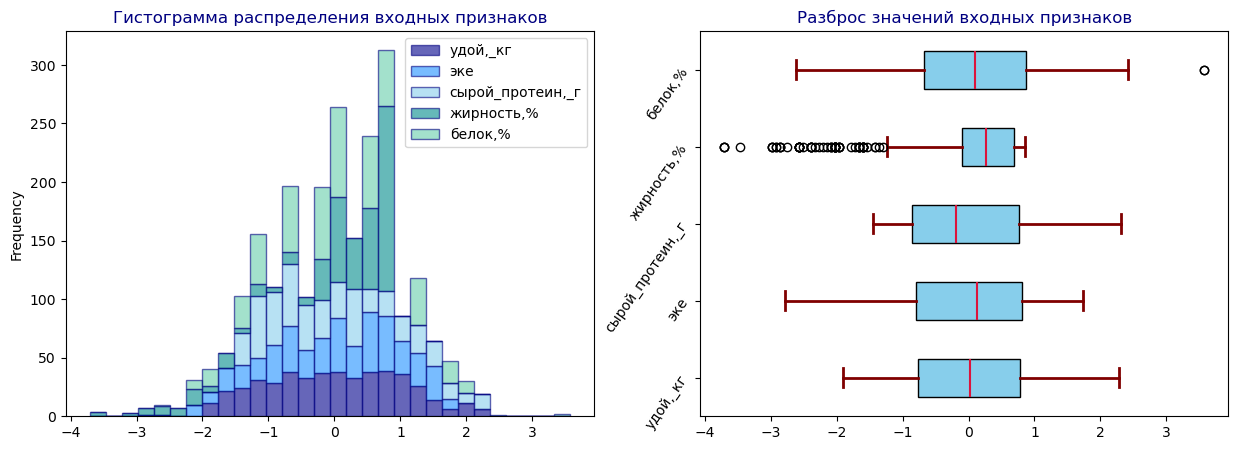

In [171]:
#визуализируем разброс признаков тренировочной выборки
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
X_log_train_c[all_num_col].plot(kind='hist', bins=30, stacked=True, \
                              color=['darkblue', 'dodgerblue', 'skyblue', 'darkcyan', 'mediumaquamarine'], edgecolor='navy', alpha=0.6, ax=axes[0])
axes[0].set_title('Гистограмма распределения входных признаков', color='navy')
X_log_train_c[all_num_col].plot(kind='box', vert=False, patch_artist=True, boxprops = dict(facecolor = "skyblue"), \
                medianprops = dict(color = "crimson", linewidth = 1.5), \
                capprops = dict(color = "maroon", linewidth = 2), whiskerprops = dict(color = "maroon", linewidth = 2), ax=axes[1], rot=55)
axes[1].set_title('Разброс значений входных признаков', color='navy')
plt.show()

### Обучение и оценка качества модели

In [173]:
clf = LogisticRegression()
clf=clf.fit(X_log_train_c, y_log_train)
# получаем прогнозные метки классов
y_log_pred = clf.predict(X_log_test_c)

In [174]:
# выводим веса коэффициентов
for feature_number, feature_name in enumerate(X_log.columns):
    exp_weight = math.exp(clf.coef_[0, feature_number])
    print('\u001b[38;5;19m', f"{feature_name:<20}: {exp_weight :.2f}", '\u001b[0m')

 удой,_кг            : 1.04 
 эке                 : 1.69 
 сырой_протеин,_г    : 0.95 
 порода              : 1.32 
 тип_пастбища        : 0.99 
 порода_папы_быка    : 0.99 
 жирность,%          : 0.66 
 белок,%             : 0.57 
 имя_папы            : 0.82 
 возраст_бином       : 1.93 
 спо_кат             : 1.22 


<font color='Darkblue'><b><i>Больше всего на вкус влияет `возраст`

In [176]:
beef_name = ferma.pivot_table(index='возраст', columns='порода', values='вкус_молока_бином', aggfunc='sum').reset_index()
beef_name

порода,возраст,Вис Бик Айдиал,РефлешнСоверинг
0,более_2_лет,184,135
1,менее_2_лет,34,17


In [177]:
accuracy = accuracy_score(y_log_test, y_log_pred)
recall = recall_score(y_log_test, y_log_pred)
precision = precision_score(y_log_test, y_log_pred)
print('\u001b[38;5;19m', 'Показатели качества модели: \n - accuracy - {:.3f} \n - recall - {:.3f} \n - precision - {:.3f}'.format(accuracy, recall, precision), '\u001b[0m')

 Показатели качества модели: 
 - accuracy - 0.624 
 - recall - 0.864 
 - precision - 0.618 


<font color='Darkblue'>Показатели точности прогноза (доля правильных прогнозов) - accuracy, и точность, с которой модель присваивает объектам класс 1, - precision, довольно низкого уровня - 0.624 и 0.618 соответсвенно<br>Однако показатель, отражающий насколько модель смогла присвоить 1 класс всем объектам этого класса - recall, достаточно высок - 0.864

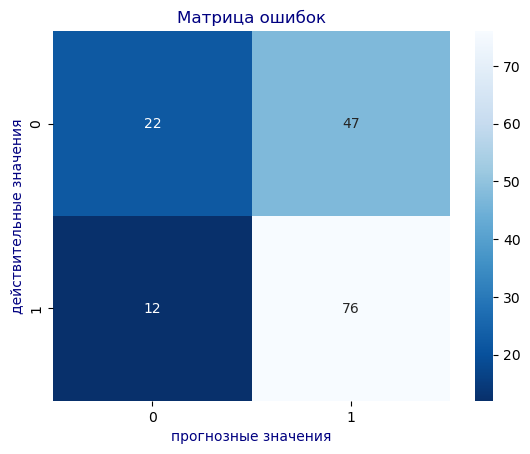

In [179]:
# посмотрим на матрицу ошибок
cm = confusion_matrix(y_log_test, y_log_pred)
sns.heatmap(cm, annot=True, \
           fmt = 'd', cmap = 'Blues_r')
plt.title('Матрица ошибок', color='navy')
plt.ylabel('действительные значения', color='navy')
plt.xlabel('прогнозные значения', color='navy')
plt.show()

<font color='Darkblue'> Матрица ошибок показывает, что<br><b>✔️ модель допускает ошибку 2го рода (FN)</b> - ошибочно определяет вкус молока как невкусное<b> 12 раз</b>,<br>✔️ <b>модель допускает ошибку 1го рода (FP)</b>, т.е. ошибочно определяет невкусное молоко как вкусное - <b>47 раз</b>.<br>С учетом того, что при приобретении коров, важнее снижение ошибки 1го рода, посмотрим возможные варианты изменения порога классификации, которые приведут к увеличению показателя precision

### Порог классификации и изменение показателей качества модели

In [182]:
# подберем порог, чтобы максимизировать показатель precision
y_proba = clf.predict_proba(X_log_test_c)[:,1]
y_valid_and_proba = pd.DataFrame(zip(y_log_test, y_proba, y_log_pred), \
                                 columns = ['y_valid', 'y_proba', 'y_pred']). sort_values(by='y_proba', ascending=False)
display(y_valid_and_proba.sample(5))
print('Максимальное значение вероятности принадлежности к классу: ', round(y_valid_and_proba['y_proba'].max(), 3))

,y_valid,y_proba,y_pred
109,1,0.66,1
150,0,0.69,1
110,1,0.83,1
152,1,0.73,1
140,1,0.74,1


Максимальное значение вероятности принадлежности к классу:  0.854


In [183]:
# реклассифицируем вкус, в зависимости от порога присвоения класса
thresholds = [round(i, 2) for i in np.linspace(0.5, 0.85, num=35, endpoint=False)]
values = []
columns = []
for i in thresholds:
    columns.append('y_pred_' + str(i))
    y_valid_and_proba['y_pred_'+str(i)] = y_valid_and_proba['y_proba'].apply(lambda x: 1 if x> i else 0)
y_valid_and_proba.head()

,y_valid,y_proba,y_pred,y_pred_0.5,y_pred_0.51,y_pred_0.52,y_pred_0.53,y_pred_0.54,y_pred_0.55,y_pred_0.56,y_pred_0.57,y_pred_0.58,y_pred_0.59,y_pred_0.6,y_pred_0.61,y_pred_0.62,y_pred_0.63,y_pred_0.64,y_pred_0.65,y_pred_0.66,y_pred_0.67,y_pred_0.68,y_pred_0.69,y_pred_0.7,y_pred_0.71,y_pred_0.72,y_pred_0.73,y_pred_0.74,y_pred_0.75,y_pred_0.76,y_pred_0.77,y_pred_0.78,y_pred_0.79,y_pred_0.8,y_pred_0.81,y_pred_0.82,y_pred_0.83,y_pred_0.84
85,1,0.85,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
51,1,0.85,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
66,1,0.84,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
110,1,0.83,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
147,1,0.81,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0


In [184]:
# рассчитаем precision для разных порогов
precisions_by_step = pd.DataFrame(columns=['thresholds', 'precision'])
row = 0
for i in y_valid_and_proba.columns[2:]:
    precision = precision_score(y_log_test, y_valid_and_proba[i])
    precisions_by_step.loc[row] = [i, precision]
    row += 1
precisions_by_step.sort_values(by='precision', ascending=False).head()

,thresholds,precision
35,y_pred_0.84,1.00
26,y_pred_0.75,0.85
27,y_pred_0.76,0.82
29,y_pred_0.78,0.81
28,y_pred_0.77,0.79


<font color='Darkblue'> В результате подбора порога классификации видно, что <b> при пороге 0.84 показатель precision принимает максимальное значение - 1.</b><br>Следующим значением порога является порог классификации 0.75, при котором precision принимает значение 0.85 - допустимый уровень риска: 4 из 147 коров ложноположительные

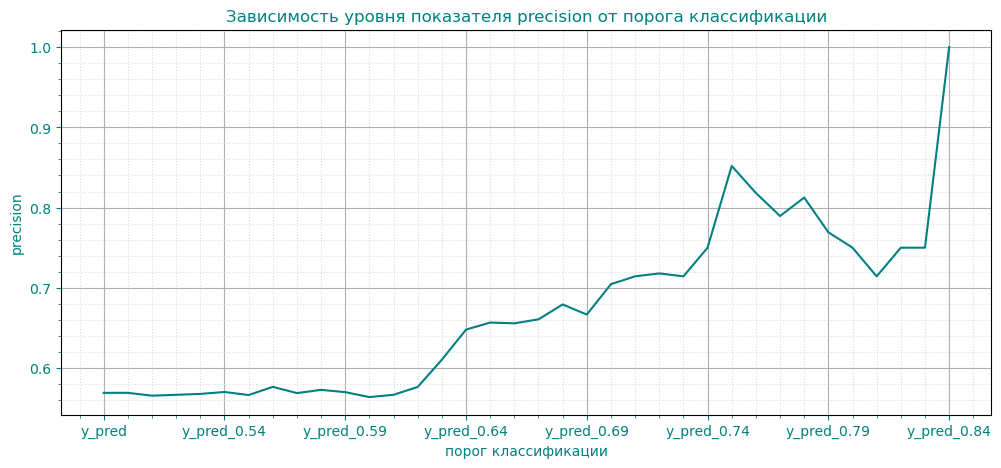

In [186]:
maximums = precisions_by_step['thresholds']
precisions_by_step.plot(x='thresholds', y='precision', figsize = (12, 5), color='teal', grid=True, legend=False)
plt.title('Зависимость уровня показателя precision от порога классификации', color='teal')
plt.xlabel('порог классификации', color='teal')
plt.tick_params(colors='teal', which='both')
plt.ylabel('precision', color='teal')
plt.minorticks_on()
plt.grid(which='minor', color='gainsboro', ls=':')
plt.show();

### Метрики модели с измененным порогом классификации

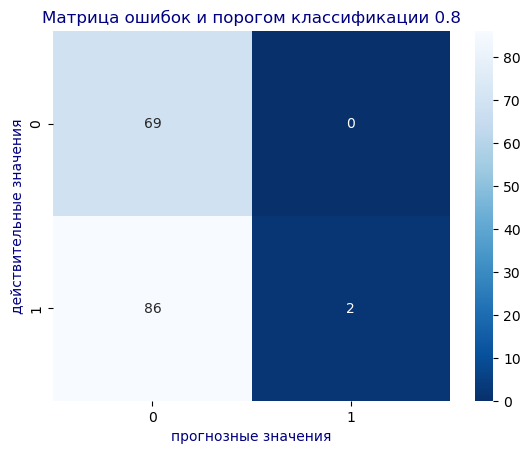

In [188]:
# посмотрим на матрицу ошибок с порогом классификации = 0.84
cm = confusion_matrix(y_valid_and_proba['y_valid'], y_valid_and_proba['y_pred_0.84'])
sns.heatmap(cm, annot=True, \
           fmt = 'd', cmap = 'Blues_r')
plt.title('Матрица ошибок и порогом классификации 0.8', color='navy')
plt.ylabel('действительные значения', color='navy')
plt.xlabel('прогнозные значения', color='navy')
plt.show()

In [189]:
accuracy_new = accuracy_score(y_valid_and_proba['y_valid'], y_valid_and_proba['y_pred_0.84'])
recall_new = recall_score(y_valid_and_proba['y_valid'], y_valid_and_proba['y_pred_0.84'])
precision_new = precision_score(y_valid_and_proba['y_valid'], y_valid_and_proba['y_pred_0.84'])
print('\u001b[38;5;19m', 'Показатели качества модели с порогом классификации 0.84: \n - accuracy - {:.3f} \n - recall - {:.3f} \n - precision - {:.3f}'.format(accuracy_new, recall_new, precision_new), '\u001b[0m')

 Показатели качества модели с порогом классификации 0.84: 
 - accuracy - 0.452 
 - recall - 0.023 
 - precision - 1.000 


### Резюме

<font color='Darkblue'>1. С целью формирования прогноза вкусовых характеристик молока была сформирована модель логистической регрессии на основании данных о характеристиках поголовья, кормов и молока фермерского хозяйства Вольный луг. В качестве признаов, влияющих на вкус молока были определены<br>&nbsp;&nbsp;&nbsp;`порода` - порода коровы, <br>&nbsp;&nbsp;&nbsp;`порода_папы_быка` - порода быка-производителя,<br>&nbsp;&nbsp;&nbsp;`имя_папы` - конкретный бык-производитель коровы,<br>&nbsp;&nbsp;&nbsp;`тип_пастбища` - тип пастбища, на котором пасется корова,<br>&nbsp;&nbsp;&nbsp;`возраст`- возраст животного<br>&nbsp;&nbsp;&nbsp;`удой` - количество молока, которое коова дает в год<br>&nbsp;&nbsp;&nbsp;`спо` - соотношение сахара к протеину в корме коровы, переведенное в категориальный признак - выше/ниже 0.91<br>&nbsp;&nbsp;&nbsp;`эке` - показатель питательности корма коровы<br>&nbsp;&nbsp;&nbsp;`сырой_протеин,_г` - показатель содержания сырого протеина в корме коровы<br>&nbsp;&nbsp;&nbsp;`жирность` - процент содержания жиров в молоке<br>&nbsp;&nbsp;&nbsp;`белок` - процент содержания белков в молоке

<font color='Darkblue'>2. Оценка качества сформированной модели показала следующий результат <br>&nbsp;&nbsp;&nbsp;- точность прогноза (доля правильных прогнозов) - accuracy, и точность, с которой модель присваивает объектам класс 1, - precision, довольно низкого уровня - 0.624 и 0.618 соответственно<br>&nbsp;&nbsp;&nbsp;- показатель, отражающий насколько модель смогла присвоить 1 класс всем объектам этого класса - recall, достаточно высок - 0.864<br>&nbsp;&nbsp;&nbsp;- модель допускает ошибку 2го рода (FN)</b> - ошибочно определяет вкус молока как невкусное<b> 12 раз</b>,<br>&nbsp;&nbsp;&nbsp;- <b>модель допускает ошибку 1го рода (FP)</b>, т.е. ошибочно определяет невкусное молоко как вкусное - <b>47 раз</b>.<br>С учетом того, что при приобретении коров, важнее снижение ошибки 1го рода, были проанализированы возможные варианты изменения порога классификации, которые приведут к увеличению показателя precision

<font color='Darkblue'>3. Повышение порога классификации с 0.5 (в стандартном варианте) до 0.85 позволило исключить вероятность ошибочного определения невкусного молока как вкусного

### Прогноз вкуса молока поголовья ЭкоФермы

#### Подготовка данных

<font color='Darkblue'>Для формирования прогноза вкуса молока поголовья Экофермы необходимо, чтобы количество признаков совпадало с количеством признаков в модели прогноза вкуса молока построенной по данным о поголовье хозяйства "Вольный луг"

In [197]:
print('\u001b[34;5;1m', 'Датасет о поголовье ЭкоФермы, содержит {} строк и {} колонок:'.format(cow_buy.shape[0], cow_buy.shape[1]), '\u001b[0m')
for name in list(cow_buy.columns.values):
    print('\u001b[38;5;19m', '- ', name, '\u001b[0m')
print('-'*100)
print('\u001b[34;5;1m', 'Датасет данных модели о поголовье Вольный луг, содержит {} строк и {} колонок'.format(X_log_train.shape[0], X_log_train.shape[1]), '\u001b[0m')
for name in list(X_log_train.columns.values):
    print('\u001b[38;5;19m', '- ', name, '\u001b[0m')

 Датасет о поголовье ЭкоФермы, содержит 20 строк и 12 колонок: 
 -  порода 
 -  тип_пастбища 
 -  порода_папы_быка 
 -  имя_папы 
 -  текущая_жирность,% 
 -  текущий_уровень_белок,% 
 -  возраст 
 -  эке_кв 
 -  спо 
 -  сырой_протеин,_г 
 -  спо_кат 
 -  удой,_кг 
----------------------------------------------------------------------------------------------------
 Датасет данных модели о поголовье Вольный луг, содержит 471 строк и 11 колонок 
 -  удой,_кг 
 -  эке 
 -  сырой_протеин,_г 
 -  порода 
 -  тип_пастбища 
 -  порода_папы_быка 
 -  жирность,% 
 -  белок,% 
 -  имя_папы 
 -  возраст_бином 
 -  спо_кат 


Из вышеприведённых данных видно, что для прогноза вкуса в датасете о поголовье ЭкоФермы надо надо исключить колонку `спо`, заменить данные об `эке в квадрате` на данные об `эке`, изменить данные о `возрасте` с более_2_лет/менее_2_лет на 1/0, а также привести в соответствие название колонок, содержащих информацию о `жирности` и `белке` молока, и выстроить колонки в одинаковом порядке.

In [199]:
X_cow_new = cow_buy
X_cow_new['эке'] = np.sqrt(X_cow_new['эке_кв'])
X_cow_new['возраст_бином'] = X_cow_new['возраст'].apply(lambda x : 1 if x=='более_2_лет' else 0)
X_cow_new = X_cow_new.rename(columns={'текущая_жирность,%': 'жирность,%', 'текущий_уровень_белок,%': 'белок,%'})
X_cow_new = X_cow_new.drop(['эке_кв', 'возраст', 'спо'], axis=1)
cow_cols_new = ['удой,_кг', 'эке', 'сырой_протеин,_г', 'порода', \
               'тип_пастбища', 'порода_папы_быка', 'жирность,%', 'белок,%', \
                'имя_папы','возраст_бином', 'спо_кат']
X_cow_new = X_cow_new[cow_cols_new]
print('\u001b[38;5;19m', 'Датасет о поголовье ЭкоФермы, содержит {} колонок: '.format(len(X_cow_new.columns.values)), '\u001b[0m')
for name in list(X_cow_new.columns.values):
    print('\u001b[38;5;19m', '- ', name, '\u001b[0m')

 Датасет о поголовье ЭкоФермы, содержит 11 колонок:  
 -  удой,_кг 
 -  эке 
 -  сырой_протеин,_г 
 -  порода 
 -  тип_пастбища 
 -  порода_папы_быка 
 -  жирность,% 
 -  белок,% 
 -  имя_папы 
 -  возраст_бином 
 -  спо_кат 


In [200]:
print('\u001b[38;5;19m', 'Размер тренировочной выборки', X_log_train.shape, '\u001b[0m')
print('\u001b[38;5;19m', 'Размер тестовой выборки', X_cow_new.shape, '\u001b[0m')

 Размер тренировочной выборки (471, 11) 
 Размер тестовой выборки (20, 11) 


#### Кодирование и масштабирование данных

In [202]:
all_cat_col = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст_бином', 'имя_папы', 'спо_кат']
all_num_col = ['удой,_кг', 'эке', 'сырой_протеин,_г', 'жирность,%', 'белок,%']

In [203]:
# перед кодированием проверим совпадение и последовательность названий колонок
print('Колонки X_log_train -', X_log_train[all_cat_col].columns.values)
print('Колонки X_cow_new -', X_cow_new[all_cat_col].columns.values)

Колонки X_log_train - ['порода' 'тип_пастбища' 'порода_папы_быка' 'возраст_бином' 'имя_папы'
 'спо_кат']
Колонки X_cow_new - ['порода' 'тип_пастбища' 'порода_папы_быка' 'возраст_бином' 'имя_папы'
 'спо_кат']


In [204]:
# проведем кодирование категориальных данных
X_cow_new_ohe = encoder_2.transform(X_cow_new[all_cat_col])
X_cow_new_ohe = pd.DataFrame(X_cow_new_ohe, columns=encoder_col_names_log)


In [205]:
# перед масштабирование проверим совпадение и последовательность названий колонок
print('Колонки X_log_train -', X_log_train[all_num_col].columns.values)
print('Колонки X_cow_new -', X_cow_new[all_num_col].columns.values)

Колонки X_log_train - ['удой,_кг' 'эке' 'сырой_протеин,_г' 'жирность,%' 'белок,%']
Колонки X_cow_new - ['удой,_кг' 'эке' 'сырой_протеин,_г' 'жирность,%' 'белок,%']


In [206]:
# проведем масштабирование количественных данных
X_cow_new_scaled = scaler_2.transform(X_cow_new[all_num_col])

X_cow_new_scaled = pd.DataFrame(X_cow_new_scaled, columns=all_num_col)


In [207]:
# объединим отмасштабированные и закодированные признаки в один датафрейм

X_cow_new_c = pd.concat([X_cow_new_ohe, X_cow_new_scaled], axis=1)

#### Прогноз вкуса молока поголовья ЭкоФермы

In [209]:
X_log_train_c_cols = X_log_train_c.columns.values
X_log_train_c_cols

array(['порода_РефлешнСоверинг', 'тип_пастбища_Холмистое',
       'порода_папы_быка_Соверин', 'возраст_бином_1', 'имя_папы_Буйный',
       'имя_папы_Геркулес', 'имя_папы_Соловчик', 'спо_кат_1', 'удой,_кг',
       'эке', 'сырой_протеин,_г', 'жирность,%', 'белок,%'], dtype=object)

In [210]:
X_cow_new_c = X_cow_new_c[X_log_train_c_cols]
X_cow_new_c.columns.values

array(['порода_РефлешнСоверинг', 'тип_пастбища_Холмистое',
       'порода_папы_быка_Соверин', 'возраст_бином_1', 'имя_папы_Буйный',
       'имя_папы_Геркулес', 'имя_папы_Соловчик', 'спо_кат_1', 'удой,_кг',
       'эке', 'сырой_протеин,_г', 'жирность,%', 'белок,%'], dtype=object)

In [211]:
# получаем прогнозные метки классов
y_cow_new_pred = clf.predict(X_cow_new_c)
print('\u001b[34;5;1m', 'Из 20 коров, вкусное молоко по модели с порогом 0.5 спрогнозировано у', y_cow_new_pred.sum())

 Из 20 коров, вкусное молоко по модели с порогом 0.5 спрогнозировано у 13


In [212]:
y_cow_pred_proba = clf.predict_proba(X_cow_new_c)[:,1]
cow_buy['вкус_молока'] = y_cow_pred_proba
cow_buy['вкус_молока'] = cow_buy['вкус_молока'].apply(lambda x: 'вкусно' if x >=0.84 else 'не_вкусно')
print('\u001b[34;5;1m', 'Из 20 коров, вкусное молоко по модели с порогом 0.84 спрогнозировано у',cow_buy.query('вкус_молока == "вкусно"')['порода'].count())

 Из 20 коров, вкусное молоко по модели с порогом 0.84 спрогнозировано у 0


In [213]:
print('\u001b[34;5;1m', 'Максимальное значение порога классификации -', round(y_cow_pred_proba.max(), 3), '\u001b[0m')
print('\u001b[34;5;1m', 'Коров дающих молоко, классифицированное как вкусное, при условии увеличенного до 0.84 порога классификации, \nнивелирующего ошибку 1го рода (ошибочное определение невкусного молока, как вкусного), в стаде Экофермы', cow_buy.query('вкус_молока == "вкусно"')['порода'].count(), '\u001b[0m')

 Максимальное значение порога классификации - 0.737 
 Коров дающих молоко, классифицированное как вкусное, при условии увеличенного до 0.84 порога классификации, 
нивелирующего ошибку 1го рода (ошибочное определение невкусного молока, как вкусного), в стаде Экофермы 0 


### Резюме

<font color='Darkblue'> По итогу прогноза вкуса молока поголовья ЭкоФермы на основе модели логистической регресии, сформированной на основе показателей, влияющих на вкусовые характеристики молока и сформированных по поголовью хозяйства Вольный Луг, можно сделать следующие выводы<br>✔️<b>в стаде Экофермы 13 коров, которые моделью были отнесены к группе, дающих "вкусное" молоко</b><br>✔️<b>при увеличени порога классификации</b> молока коров до уровня, позволяющего нивелировать вреоятность идентификации коровы с "невкусным" молоком как коровы с "вкусным" молоком, <b>коров в стаде ЭкоФермы, прогноз по молоку которых - "вкусное", нет.</b><br><i>Их также не будет и при чуть более низком уровне - 0.75, который хоть и не со 100% вероятностью снижает ошибку, но с допустимым уровнем риска

## Результаты прогноза показателей поголовья ЭкоФермы

In [217]:
# оформим результаты прогноза удоя и классификации молока экоФермы в таблицу
result = cow_buy[['порода', 'порода_папы_быка', 'имя_папы', 'возраст', 'тип_пастбища', \
                          'удой,_кг', 'текущая_жирность,%', 'текущий_уровень_белок,%', 'вкус_молока']]
result = result.rename(columns={'удой,_кг':'milk', 'вкус_молока':'taste'})
result

,порода,порода_папы_быка,имя_папы,возраст,тип_пастбища,milk,"текущая_жирность,%","текущий_уровень_белок,%",taste
0,Вис Бик Айдиал,Айдиал,Геркулес,более_2_лет,Холмистое,"6,608.44",3.58,3.08,не_вкусно
1,Вис Бик Айдиал,Соверин,Буйный,менее_2_лет,Равнинное,"6,334.28",3.54,3.08,не_вкусно
2,РефлешнСоверинг,Соверин,Барин,более_2_лет,Равнинное,"6,281.14",3.59,3.07,не_вкусно
3,РефлешнСоверинг,Айдиал,Буйный,более_2_лет,Холмистое,"6,592.03",3.40,3.06,не_вкусно
4,РефлешнСоверинг,Айдиал,Буйный,более_2_лет,Равнинное,"6,543.03",3.64,3.07,не_вкусно
5,РефлешнСоверинг,Соверин,Геркулес,менее_2_лет,Равнинное,"6,380.17",3.63,3.05,не_вкусно
6,Вис Бик Айдиал,Айдиал,Геркулес,более_2_лет,Холмистое,"6,608.44",3.58,3.08,не_вкусно
7,Вис Бик Айдиал,Соверин,Буйный,более_2_лет,Равнинное,"6,528.29",3.57,3.08,не_вкусно
8,РефлешнСоверинг,Соверин,Барин,более_2_лет,Равнинное,"6,281.14",3.59,3.07,не_вкусно
9,РефлешнСоверинг,Айдиал,Буйный,менее_2_лет,Холмистое,"6,398.01",3.40,3.08,не_вкусно


In [218]:
# Сформируем данные о коровах, чей удой выше 6000 кг/год и вкусное молоко
result.query('milk >= 6000 and taste == "вкусно"')

,порода,порода_папы_быка,имя_папы,возраст,тип_пастбища,milk,"текущая_жирность,%","текущий_уровень_белок,%",taste


<font color='Darkblue'>Таким образом, в результате работы моделей, сформированных на базе данных о поголовье фермерского хозяйства Вольный Луг, в отношении поголовья ЭкоФермы можно сказать следующее:<br>1. <b>прогноз удоя молока поголовья Экофермы находится в диапазоне от 6.121,39 до 6.608,44 кг/год</b>, при среднем значении 6.443,07 кг/год, что немного превышает доверительный диапазон, сформированный при тестировании модели на показателях фермерского хозяйства.<br>2. В стаде Экофермы выявлено 13 коров, которые моделью были отнесены к коровам , дающим вкусное молоко.<br><i><b>Однако прогноз модели имеет вероятность ошибочного определения молока как вкусного, тогда как по параметрам фермерского хозяйства он является невкусным. При сведении этого риска к минимум коров, в стаде Экофермы, отвечающих парамерам вкусного молока нет. 

## Выводы

<font color='Darkblue'><b>I.</b> Для исследования предоставлено 3 датасета<br>&nbsp;&nbsp;&nbsp;<b>1) ferma_main</b> - данные о стаде фермера на текущий момент<br>&nbsp;&nbsp;&nbsp;<i>634 записи, 12 колонок, 5 дубикатов записей (неявных дубликатов нет), пропусков данных нет</i><br>`id` - уникальный идентификатор коровы,<br>`удой` - масса молока, которую корова даёт в год (в килограммах)<br>`ЭКЕ (Энергетическая кормовая единица)` -  показатель питательности корма коровы<br>`Сырой протеин, г` - содержание сырого протеина в корме (в граммах)<br>`СПО (Сахаро-протеиновое соотношение)` - отношение сахара к протеину в корме коровы<br>`Порода` - порода коровы<br>`Тип пастбища` - ландшафт лугов, на которых паслась корова<br>`порода папы_быка` - порода папы коровы<br>`Жирность,%` - содержание жиров в молоке<br>`Белок,%` - содержание беков в молоке<br>`Вкус молока` -  оценка вкуса по личным критериям фермера<br>`Возраст` - возраст коровы<br>&nbsp;&nbsp;&nbsp;<b>2) ferma_dad</b> - имя папы каждой коровы в стаде фермера<br>&nbsp;&nbsp;&nbsp;<i>629 записей, 2 колонки, дубликатов и пропусков записей нет</i><br>`id` - уникальный идентификатор коровы<br>`имя папы` - имя папы коровы<br>&nbsp;&nbsp;&nbsp;<b>3) cow_buy</b> - данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой<br>&nbsp;&nbsp;&nbsp;<i>20 записей, 7 колонок, 4 дубликата, пропусков данных нет</i><br>`Порода` - порода коровы<br>`тип_пастбища` - ландшафт лугов, на которых паслась корова<br>`порода папы быка` - порода папы коровы<br>`имя папы` - имя папы коровы<br>`текущая жирность,%` - содержание жиров в молоке<br>`текущий уровень белок,%` - содержание белков в молоке<br>`возраст` - возраст коровы<br><font color='Darkblue'>B. В рамках предподготовки данных выявленные дубликаты в данных о поголовье ЭкоФермы не удалены, т.к. предполагается, что это разные животные, наименовани колонок приведены к стандарту<br>

<font color='Darkblue'><b>II.</b><b> Данныео поголовье хозяйства "Вольный луг"</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>A.</b><b> Количественные данные</b><br>
<font color='Darkblue'>1. Показатели кормовой базы:<br>&nbsp;&nbsp;&nbsp;- `эке (энергетические кормовые единицы)`: показатель нормально распределен, у 75% поголовья в рационе эко в рационе находится в диапазоне 12.9-16.2 ед., средние эке составляют 14.5 и смещено влево от наиболее распространенного (15.5) и медианного (14.7) значений,<br>&nbsp;&nbsp;&nbsp;- `сырой протеин`: ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды), у 75% поголовья в рационе сырой протеин в рационе находится в диапазоне 1.7 - 2.2 тыс гр., средний протеин составляют 1.92 тыс.гр. и смещен вправо от наиболее распространенного (1.75 тыс.гр) и медианного значений(1.89 тыс.гр), ,<br>&nbsp;&nbsp;&nbsp;- `спо (сахаро-протеиновое соотношение)`: на гистограмме видны три четкие области концентрации значений - в диапазоне от 0.84 до 0.86, в диапазоне от 0.88 до 0.90 и в диапазоне от 0.93 до 0.96, где сконцентрированно наибольшее количество значений, средний показатель спо составляет 0.91<br>2. Показатели молока:<br>&nbsp;&nbsp;&nbsp;- `удой`(после удаления аномального значения): показатель нормально распределен, у 75% поголовья удой нахдоится в диапазоне 5.5 - 6.7 тыс кг/год, средний и медианный удой составляет 6.1 тыс кг/год и незначительно смещен влево от наиболее распространенного (6.5) значения,<br>&nbsp;&nbsp;&nbsp;- `жирность`: ассиметричное распределение значений показателя - отрицательная ассиметрия (большинство значений показателя расположена слева от моды), видно 2 четкие области концентрации значений - около 3.6% и около 3.7%, где сконцентрированно наибольшее количество значений, средний показатель жирности составляет 3.6%, что не сильно отличается от медианного - 3.65%,<br>&nbsp;&nbsp;&nbsp;- `белок`: незначительное ассиметричное смещение значений показателя в диапазоне 3.07% - 3.08%, средний и медианный показатель белка совпададют и составляют 3.08%<br>
<font color='Darkblue'><b>B.</b><b> Категорийные данные о поголовье хозяйства "Вольный луг"</b><br>&nbsp;&nbsp;&nbsp;1) `порода` - в стаде представлено две породы: ВисБикАйдал и РефлешнсСоверинг, - незначительно превалируют коровы породы ВисБикАйдал (59.2%)<br>&nbsp;&nbsp;&nbsp;2) `порода быков-производителей` - в стаде 50Х50 представлены коровы от двух пород быков: Айдиал и Соверин<br>&nbsp;&nbsp;&nbsp;3) `имя быка производителя` - в стаде потомство от 4х быков, наибольшая доля голов от быка Барин (38.2%) и быка Буйный (34.1%)<br>&nbsp;&nbsp;&nbsp;4) `пастбища` - два типа пастбищ: Равнинное и Холмистое, - незначительно превалирует поголовье, с выпасом на Холмистых пастбищах (55.7%)<br>&nbsp;&nbsp;&nbsp;5) `вкус молока` - незначительно, но превалирует оценка вкусно - 58.9%<br>&nbsp;&nbsp;&nbsp;6) `возраст коров` - в стаде превалируют животные старше 2х лет - 82.5%

<font color='Darkblue'><b>III.</b><b> Данныео поголовье "ЭкоФермы"</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>A.</b><b> Количественные данные</b><br>
<font color='Darkblue'>Показатели молока:<br>&nbsp;&nbsp;&nbsp;- `жирность`: показатель неравномерно распределен, видно 3 четкие области концентрации значений - 3.4%, 3.8% и 3.55-3.65, где сконцентрированно наибольшее количество значений, средний показатель жирности составляет 3.58%, что не сильно отличается от медианного - 3.59% ,<br>&nbsp;&nbsp;&nbsp;- `белок`: показатель также неравномерно, наибольшее количество значений приходится на диапазон от 3.05% - 3.08%, медианное и среднее значение совпадают - 3.07%<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>B.</b><b> Категорийные данные </b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;1) `порода` - в стаде 45Х55 представлено две породы: ВисБикАйдал и РефлешнсСоверинг<br>&nbsp;&nbsp;&nbsp;2) `порода быков-производителей` - в стаде представлены коровы от двух пород быков: Айдиал и Соверин, - превалируют коровы от быков породы Соверин (60.0%)<br>&nbsp;&nbsp;&nbsp;3) `имя быка производителя` - в стаде потомство от 4х быков, наибольшая доля голов от быка Буйный (40.0%)<br>&nbsp;&nbsp;&nbsp;4) `пастбища` - два типа пастбищ: Равнинное и Холмистое, - поголовье 55Х45 пасется на обоих типах<br>&nbsp;&nbsp;&nbsp;5) `возраст коров` - в стаде превалируют животные старше 2х лет - 75.0%

<font color='Darkblue'><b>IV.</b><b> Корреляция количественных показателей хозяйства "Вольный луг"</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;1. сильная корреляциионная взаимосвязь прослеживается между показателем удоя и энергетичечскими кормовыми единицами кормов (0.72), жирности и энергетичечскими кормовыми единицами кормов (0.72)<br>&nbsp;&nbsp;&nbsp;2. средняя корреляционная связь между показателями удоя и сахарно-протеиновым соотношением в кормах (0.66), жирности и сахарно-протеиновым соотношением в кормах(0.65)<br>&nbsp;&nbsp;&nbsp;3. на белок молока практичечски не влиет ни один из имеющихся количественных показателей, за исключением сырого протеина, с которым можно отметить очень слабую корреляцию.

<font color='Darkblue'><b>Влияние показателей поголовья хозяйства "Вольный луг" на удой</b><br>
<font color='Darkblue'><i> По всем графикам видно, что <br>&nbsp;&nbsp;&nbsp;- взаимосвязь показателя эке и удоя можно назвать линейнозависимым, но связь не очень силная, так как облако значений нельзя навать сильно вытянутым <br>&nbsp;&nbsp;&nbsp;- взаимосвязь удоя и показателя содержания сырого протеина слабая, облако значений не сконцентрировано вдоль какой-либо линии <br>&nbsp;&nbsp;&nbsp;- взаимосвязь показателя спо и удоя скорее можно охарктеризовать как кластеры - на графиках видны несколько ярковыраженных кластеров значений
<font color='Darkblue'><b>1. Порода коровы и порода/имя быка производителя</b><br>&nbsp;&nbsp;&nbsp;- удой в равной степени растет с показателем эке по обеим представленным в стаде породам<br>&nbsp;&nbsp;&nbsp;- рост сырого протеина в кормах несущественно влияет на рост удоев вне зависимости от породы коровы<br>&nbsp;&nbsp;&nbsp;- наибольшие удои отмечаются при высоком уровне СПО 0.93-0.95 и в этом кластере превалируют коровы породы РефлешнСоверинг<br>
<font color='Darkblue'><b>2. Порода/имя быка производителя</b><br>&nbsp;&nbsp;&nbsp;- удой стабильно выше у коров, от быков породы Айдиал и с именем Буйный<br>&nbsp;&nbsp;&nbsp;- рост сырого протеина в кормах несущественно влияет на рост удоев вне зависимости от имени быка производителя, однако для породы быков видно, что при одних и тех же значениях протеина удойность коров от быков породы Айдиал выше<br>&nbsp;&nbsp;&nbsp;- - наибольшие удои отмечаются при высоком уровне СПО 0.93-0.95 и в этом кластере заметно превалируют коровы от быков породы Айдиал и по имени Буйный<br>
<font color='Darkblue'><b>3. Возраст коровы</b><br>&nbsp;&nbsp;&nbsp;- поскольку животные старше 2х лет восновном показывают более высокие уровни удоя, то и все выше указанное влияние показателей на удойность у этой группы выше<br>
<font color='Darkblue'><b>4. Тип пастбища коровы</b><br>&nbsp;&nbsp;&nbsp;- у хозяйства доля коров, пасущихся на холмистых пастбищах несколько выше (55.7%) с этим связано, как и в случае с возрастом коров, бОльшая выраженность влияния вышеуказанных факторов на удои: коровы, пасущиеся на Холмистых пастбищах, дают больший прирост удоев, при росте ЭКЕ, протеина и СПО<br>
<font color='Darkblue'><b>5. Вкус молока</b><br>&nbsp;&nbsp;&nbsp;- рост ЭКЕ, приодящий к росту удоев больше прослеживается у невкусного молока<br>&nbsp;&nbsp;&nbsp;- на отметке СПО 0.93 превалирует невкусное молоко, тогда как на отметках 0.94 и 0.95 - вкусное.

<font color='Darkblue'><b>VI.</b><b> Модель линейной регрессии для прогноза удоя поголовья ЭкоФермы</b><br>
<font color='Darkblue'>1. В результате построения моделей линейной регрессии исходя из данных фермерского хозяйства "Вольный луг" о поголовье и кормах , наилучшими образом показала себя модель, учитывающая следующие признаки:<br>&nbsp;&nbsp;&nbsp;`порода` - порода коровы, <br>&nbsp;&nbsp;&nbsp;`имя_папы` - конкретный бык-производитель коровы,<br>&nbsp;&nbsp;&nbsp;`тип_пастбища` - тип пастбища, на котором пасется корова,<br>&nbsp;&nbsp;&nbsp;`возраст`- возраст животного<br>&nbsp;&nbsp;&nbsp;`спо` - соотношение сахара к протеину в корме коровы, переведенное в категориальный признак - выше/ниже 0.91<br>&nbsp;&nbsp;&nbsp;`эке_кв` - показатель питательности корма коровы возведенный в квадрат<br>&nbsp;&nbsp;&nbsp;`сырой_протеин,_г` - показатель содержания сырого протеина в корме коровы<br>2. Коэффициент детерминации модели составляет - 0.83 и среднюю абсолютную ошибку 144.64 кг/год <br>3.  95% доверительный интервал по удою находится в пределах от 6092.81 кг/год до 6222.74 кг/год. <br>Средний показатель удоя составляет 6158.77 кг/год<br><b><i>4. Возможным направлением улучшения достоверности прогноза посреством модели линейной регрессии может являться формирования пула дополнительных данных о физическом сотоянии животного, таких как вес, период стельности и лактации и пр., о кормах, о матери коровы

<font color='Darkblue'><b>VII.</b><b> Модель логистической регрессии для прогноза вкуса молока поголовья ЭкоФермы</b><br>
<font color='Darkblue'>1. С целью формирования прогноза вкусовых характеристик молока была сформирована модель логистической регрессии на основании данных о характеристиках поголовья, кормов и молока фермерского хозяйства Вольный луг. В качестве признаов, влияющих на вкус молока были определены<br>&nbsp;&nbsp;&nbsp;`порода` - порода коровы,<br>&nbsp;&nbsp;&nbsp;`порода_быка-производителя` - порода быка-производителя,<br>&nbsp;&nbsp;&nbsp;`имя_папы` - имя быка-производителя,<br>&nbsp;&nbsp;&nbsp;`тип_пастбища` - тип пастбища, на котором пасется корова,<br>&nbsp;&nbsp;&nbsp;`возраст`- возраст животного<br>&nbsp;&nbsp;&nbsp;`удой` - количество молока, которое коова дает в год<br>&nbsp;&nbsp;&nbsp;`спо` - соотношение сахара к протеину в корме коровы, переведенное в категориальный признак - выше/ниже 0.91<br>&nbsp;&nbsp;&nbsp;`эке_кв` - показатель питательности корма коровы возведенный в квадрат<br>&nbsp;&nbsp;&nbsp;`сырой_протеин,_г` - показатель содержания сырого протеина в корме коровы<br>&nbsp;&nbsp;&nbsp;`жирность` - процент содержания жиров в молоке<br>&nbsp;&nbsp;&nbsp;`белок` - процент содержания белков в молоке<br>
<font color='Darkblue'>2. Оценка качества сформированной модели показала следующий результат <br>&nbsp;&nbsp;&nbsp;- точность прогноза (доля правильных прогнозов) - accuracy, и точность, с которой модель присваивает объектам класс 1, - precision, довольно низкого уровня - 0.624 и 0.618 соответственно<br>&nbsp;&nbsp;&nbsp;- показатель, отражающий насколько модель смогла присвоить 1 класс всем объектам этого класса - recall, достаточно высок - 0.864<br>&nbsp;&nbsp;&nbsp;- модель допускает ошибку 2го рода (FN)</b> - <i>ошибочно определяет вкус молока как невкусное - 12 раз</i></b>,<br>&nbsp;&nbsp;&nbsp;- <b>модель допускает ошибку 1го рода (FP)</b>, т.е.<i> ошибочно определяет невкусное молоко как вкусное - 47 раз</i></b>.<br>С учетом того, что при приобретении коров, важнее снижение ошибки 1го рода, были проанализированы возможные варианты изменения порога классификации, которые приведут к увеличению показателя precision<br>
<font color='Darkblue'>3. Повышение порога классификации с 0.5 (в стандартном варианте) до 0.84 позволило исключить вероятность ошибочного определения невкусного молока как вкусного<br>
<font color='Darkblue'><b><i>4. Возможным направлением улучшения достоверности прогноза посредством модели логистической регрессии может являться формирования пула дополнительных данных в первую очередь о кормах, о молоке

<font color='Darkblue'><font color='Darkblue'><b>VIII.</b><b> Результаты прогноза показателей</b><br>
<font color='Darkblue'>Прогноз моделей, сформированных на базе данных о поголовье фермерского хозяйства Вольный Луг, в отношении показателей удойности и вкуса молока поголовья ЭкоФермы показал следующее:<br>&nbsp;&nbsp;&nbsp;1. <b>Прогнозный удой поголовья ЭкоФермы находится в диапазоне от 6.121,39 до 6.608,44 кг/год</b>, при среднем значении 6.443,07 кг/год, что немного превышает доверительный диапазон, сформированный при тестировании модели на показателях фермерского хозяйства Вольный Луг.<br>&nbsp;&nbsp;&nbsp;2. <b>В стаде Экофермы выявлено 13 коров, вкус молока которых спрогнозированн как "вкусное молоко".<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Однако прогноз модели имеет вероятность ошибочного определения молока как вкусного, тогда как по параметрам фермерского хозяйства оно является невкусным. При сведении этого риска к минимуму, коров, дающих вкусное молоко, в стаде Экофермы нет. 